# About the script

- Case Study Round of Interviewing Test

- Author: La Ngoc Thuy An

- Presentation [here](https://docs.google.com/presentation/d/1lnDQDusoNpa-9N-LvSjEDdKCNzr-0nIp8pxwqbb0rvQ)

# Guid to use: must run all cells within ***bold italic section***

## ***Basic import***

In [ ]:
import torch
import torchvision
import torchvision.models as models

In [ ]:
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **1. Prepare data**

## ***Read data***

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Edit datapath here

In [ ]:
datapath='/content/drive/My Drive/Colab Notebooks/Amanotes/ML-technicaltest-ecommerce.csv'

In [ ]:
data_full = pd.read_csv(datapath, dtype='str') #encoding='utf8', error_bad_lines=False
data_full.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...      17850  United Kingdom
1    536365     71053  ...      17850  United Kingdom
2    536365    84406B  ...      17850  United Kingdom
3    536365    84029G  ...      17850  United Kingdom
4    536365    84029E  ...      17850  United Kingdom

[5 rows x 7 columns]

## *Formating*

In [ ]:
data_full['Quantity'] = np.array(data_full['Quantity']).astype(int)
data_full['UnitPrice'] = np.array(data_full['UnitPrice']).astype(float)
for col in ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']:
    data_full[col]=data_full[col].astype('string')

In [ ]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  string 
 1   StockCode    541909 non-null  string 
 2   Description  540455 non-null  string 
 3   Quantity     541909 non-null  int64  
 4   UnitPrice    541909 non-null  float64
 5   CustomerID   406829 non-null  string 
 6   Country      541909 non-null  string 
dtypes: float64(1), int64(1), string(5)
memory usage: 28.9 MB


## Check key of DataFrame

In [ ]:
print (len(data_full[['InvoiceNo', 'StockCode']].drop_duplicates()))
len(data_full[['InvoiceNo', 'StockCode']].drop_duplicates()) *1.0/len(data_full)

531225


0.9802845127133891

In [ ]:
print ('The number of unique items by Description: ', data_full.Description.nunique())
print ('The number of unique items by StockCode: ', data_full.StockCode.nunique())

The number of unique items by Description:  4223
The number of unique items by StockCode:  4070


## ***Prepare Train-Test***

In [ ]:
data_full.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...      17850  United Kingdom
1    536365     71053  ...      17850  United Kingdom
2    536365    84406B  ...      17850  United Kingdom
3    536365    84029G  ...      17850  United Kingdom
4    536365    84029E  ...      17850  United Kingdom

[5 rows x 7 columns]

In [ ]:
np.random.seed(0)
Invoice_list = data_full.InvoiceNo.unique()
rand_idx = np.random.randint(0, len(Invoice_list), len(Invoice_list))
Invoice_train, Invoice_test = Invoice_list[rand_idx][:int(0.9*len(Invoice_list))], Invoice_list[rand_idx][int(0.9*len(Invoice_list)):]
data, test_data = data_full[data_full.InvoiceNo.isin(Invoice_train)], data_full[data_full.InvoiceNo.isin(Invoice_test)]
print (len(Invoice_train), data.InvoiceNo.nunique(), len(Invoice_test), test_data.InvoiceNo.nunique())
data.head()

23310 15411 2590 2474


InvoiceNo StockCode  ... CustomerID         Country
7     536366     22633  ...      17850  United Kingdom
8     536366     22632  ...      17850  United Kingdom
9     536367     84879  ...      13047  United Kingdom
10    536367     22745  ...      13047  United Kingdom
11    536367     22748  ...      13047  United Kingdom

[5 rows x 7 columns]

In [ ]:
print ('Number of purchases in full data: ', len(data_full))
print ('Number of purchases in training data: ', len(data))
print ('Number of purchases in testing data: ', len(test_data))
print ('Number of Invoices in full data: ', data_full.InvoiceNo.nunique())
print ('Number of Invoices in training data: ', data.InvoiceNo.nunique())
print ('Number of Invoices in testing data: ', test_data.InvoiceNo.nunique())

Number of purchases in full data:  541909
Number of purchases in training data:  315838
Number of purchases in testing data:  53911
Number of Invoices in full data:  25900
Number of Invoices in training data:  15411
Number of Invoices in testing data:  2474


**Save testing data until the evaluation step. From now, just explore training data**

---

# **2. Exploring data**

**2.1 Objects of purchases**

- Invoice
- Products: StockCode and Desciption
- Users

**2.2 Feature of purchases**

Target: the tendency of purchases. If there is a big difference between values of features (such as countries), we should customize our recommendation by specific features (e.g locations).

- Country
- Quantity and UnitPrice


### ***Function***

In [ ]:
product_key, user_key, full_key = ['StockCode'], ['CustomerID'], ['InvoiceNo', 'StockCode', 'CustomerID', 'UnitPrice', 'Quantity']

def get_productcnt(data): #number of purchases of products
    return data.StockCode.value_counts().reset_index(name='product_cnt').rename(columns={'index':'StockCode'})

def get_usercnt(data): #number of purchases of customers
    return data.CustomerID.value_counts().reset_index(name='user_cnt').rename(columns={'index':'CustomerID'})

def get_user_productcnt(data): #feature of users - average product_cnt
    product_cnt = get_productcnt(data)
    tmp = data[['InvoiceNo', 'StockCode', 'CustomerID']].drop_duplicates()
    tmp2 = pd.merge(tmp, product_cnt, on=product_key)
    tmp3 = tmp2.groupby(['CustomerID'])['product_cnt'].mean().reset_index(name='avg_productcnt')
    return tmp3

def get_user_invoicelen(data, metric = 'Average Invoices Length'): #feature of users - average of invoice length
    tmp = data.groupby(['CustomerID','InvoiceNo'])['StockCode'].nunique().reset_index(name = 'Number of products in Invoices')
    tmp = tmp.groupby(['CustomerID'])['Number of products in Invoices'].mean().reset_index(name=metric)
    return tmp

def compare_upvsquan(data, object_col):
    tmp = data[(pd.isnull(data[object_col])==False) & (data.UnitPrice>0) & (data.Quantity>0)]
    obj_quan = tmp.groupby([object_col])['Quantity'].mean().reset_index(name='mean_quantity')
    obj_up = tmp.groupby([object_col])['UnitPrice'].mean().reset_index(name='mean_unitprice')
    tmp = pd.merge(obj_quan, obj_up, on =[object_col], how = 'inner')
    print (tmp.head())
    snb.jointplot(x=np.log(tmp.mean_quantity+1e-10), y=np.log(tmp.mean_unitprice+1e-10), kind='kde')
    print ('mean_quantity and mean_unitprice of %s after applying log Transformation' % object_col)
    plt.show()

## 2.1 Overview Objects

- **Basic information**

In [ ]:
print (len(data))
data.info()

315838
<class 'pandas.core.frame.DataFrame'>
Int64Index: 315838 entries, 7 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    315838 non-null  string 
 1   StockCode    315838 non-null  string 
 2   Description  314952 non-null  string 
 3   Quantity     315838 non-null  int64  
 4   UnitPrice    315838 non-null  float64
 5   CustomerID   239568 non-null  string 
 6   Country      315838 non-null  string 
dtypes: float64(1), int64(1), string(5)
memory usage: 19.3 MB


In [ ]:
print ('Missing rate of columns: ')
for i in data.columns:
    print ('+ %s: %f' % (i, np.sum(pd.isnull(data[i]))/len(data)))

Missing rate of columns: 
+ InvoiceNo: 0.000000
+ StockCode: 0.000000
+ Description: 0.002805
+ Quantity: 0.000000
+ UnitPrice: 0.000000
+ CustomerID: 0.241485
+ Country: 0.000000


In [ ]:
print ('The number of unique invoice: ', data['InvoiceNo'].nunique())
print ('Special cases of invoice: ')
print (' + None or multiple countries: ', np.sum(data.groupby(['InvoiceNo'])['Country'].nunique().reset_index(name='cnt')['cnt']!=1))
print (' + Negative Quantity: ', data[data.Quantity<0].InvoiceNo.nunique())
print (' + Negative Unit Price: ', data[data.UnitPrice<0].InvoiceNo.nunique())
print ('\nThe number of unique items by StockCode: ', data.StockCode.nunique())
print ('The number of unique items by Description: ', data.Description.nunique())
print ('\nThe number of unique users/customeres: ', data.CustomerID.nunique())

The number of unique invoice:  15411
Special cases of invoice: 
 + None or multiple countries:  0
 + Negative Quantity:  3129
 + Negative Unit Price:  1

The number of unique items by StockCode:  3923
The number of unique items by Description:  4036

The number of unique users/customeres:  3669


- **The number of products in invoices**

Rate of Invoices have <50 products:  0.9177211082992668


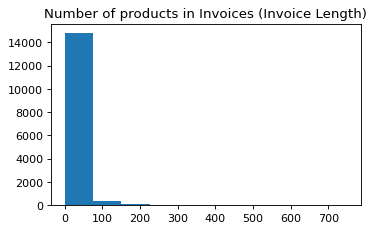

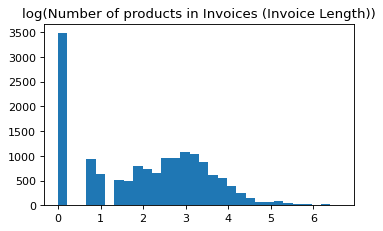

In [ ]:
metric = 'Number of products in Invoices (Invoice Length)'
tmp = data.groupby(['InvoiceNo'])['StockCode'].nunique().reset_index(name = metric)
print ('Rate of Invoices have <50 products: ', len(tmp[tmp[metric]<50])*1.0/len(tmp))
plt.figure(figsize=(5,3), dpi=80)
plt.hist(tmp[metric], bins=10)
plt.title('%s' %metric)
plt.show()
plt.figure(figsize=(5,3), dpi=80)
plt.hist(np.log(tmp[metric]), bins = 30)
plt.title('log(%s)' %metric)
plt.show()

- **The number of purchased times of products**

Based on this number can create groups of products. For short, it is also called product_cnt.

Purchased times of products (product_cnt)


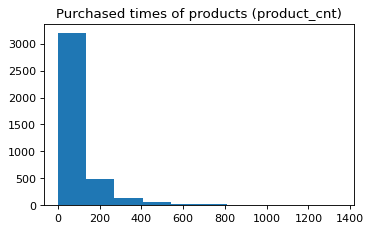

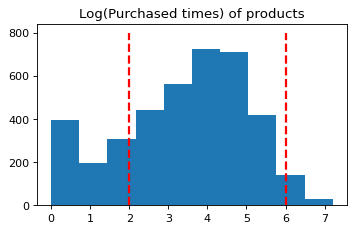

In [ ]:
print ('Purchased times of products (product_cnt)')
tmp = get_productcnt(data)

plt.figure(figsize=(5,3), dpi=80)
plt.title('Purchased times of products (product_cnt)')
plt.hist(tmp['product_cnt'])
plt.show()

plt.figure(figsize=(5,3), dpi=80)
plt.title('Log(Purchased times) of products')
plt.hist(np.log(tmp['product_cnt']))
plt.vlines(x=2, ymin=0, ymax=800, colors='r', linestyles='--', lw=2)
plt.vlines(x=6, ymin=0, ymax=800, colors='r', linestyles='--', lw=2)
plt.show()

- **The number of purchased times of users**

Based on this number can create groups of users. For short, it is also called user_cnt.

Purchasetimes of users (user_cnt)


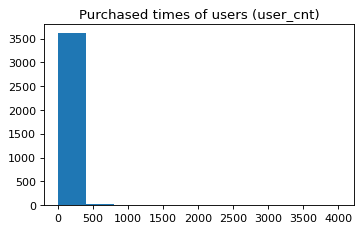

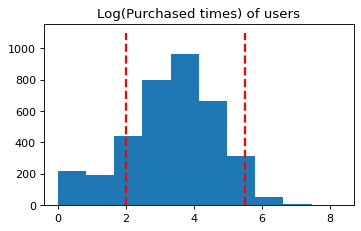

In [ ]:
print ('Purchasetimes of users (user_cnt)')
tmp = get_usercnt(data)

plt.figure(figsize=(5,3), dpi=80)
plt.title('Purchased times of users (user_cnt)')
plt.hist(tmp['user_cnt'])
plt.show()

plt.figure(figsize=(5,3), dpi=80)
plt.title('Log(Purchased times) of users')
plt.hist(np.log(tmp['user_cnt']))
plt.vlines(x=2, ymin=0, ymax=1100, colors='r', linestyles='--', lw=2)
plt.vlines(x=5.5, ymin=0, ymax=1100, colors='r', linestyles='--', lw=2)
plt.show()

- **Averaging product_cnt of users**

  CustomerID  avg_productcnt
0      12346      164.000000
1      12347      214.342466
2      12348      252.181818
3      12349      255.383562
4      12350      198.411765


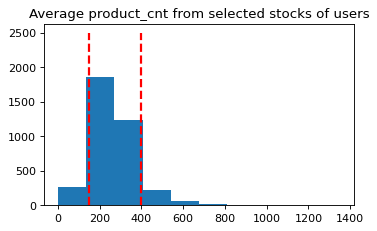

In [ ]:
tmp = get_user_productcnt(data)
print (tmp.head())

plt.figure(figsize=(5,3), dpi=80)
plt.title('Average product_cnt from selected stocks of users')
plt.hist(tmp['avg_productcnt'])

plt.vlines(x=150, ymin=0, ymax=2500, colors='r', linestyles='--', lw=2)
plt.vlines(x=400, ymin=0, ymax=2500, colors='r', linestyles='--', lw=2)
plt.show()

- **Number of products in invoices of users = Average invoices length of users**

Number of products in invoices of users (Average Invoice length of users)
  CustomerID  Average Invoice length of users
0      12346                         1.000000
1      12347                        24.333333
2      12348                         5.500000
3      12349                        73.000000
4      12350                        17.000000


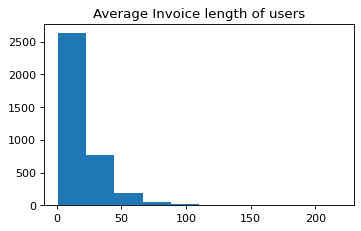

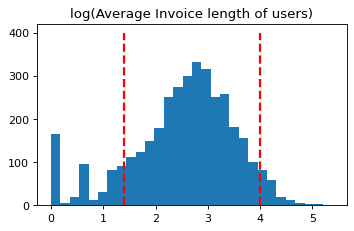

In [ ]:
print ('Number of products in invoices of users (Average Invoice length of users)')
metric = 'Average Invoice length of users'
tmp = get_user_invoicelen(data, metric)
print (tmp.head())

plt.figure(figsize=(5,3), dpi=80)
plt.hist(tmp[metric], bins=10)
plt.title('%s' %metric)
plt.show()

plt.figure(figsize=(5,3), dpi=80)
plt.hist(np.log(tmp[metric]), bins = 30)
plt.title('log(%s)' %metric)
plt.vlines(x=1.4, ymin=0, ymax=400, colors='r', linestyles='--', lw=2)
plt.vlines(x=4, ymin=0, ymax=400, colors='r', linestyles='--', lw=2)
plt.show()

- **Relationship between user features**

  CustomerID  user_cnt  avg_invoicelen  avg_productcnt
0      17841      7154       29.512821      362.173979
1      14911      5303       15.191304      370.368060
2      14096      4480      135.818182      323.766399
3      12748      4174       12.848780      321.845482
4      14606      2425       13.352459      283.805402


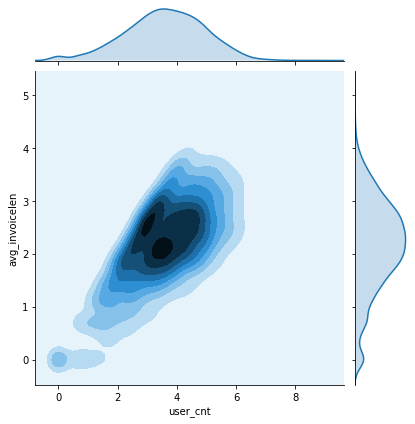

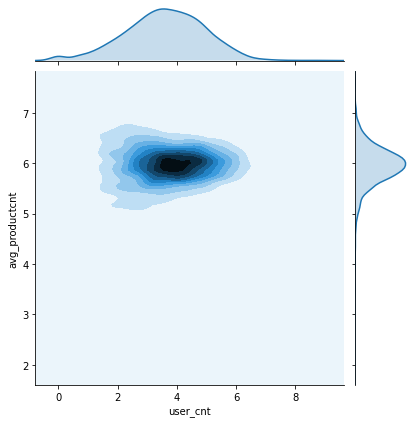

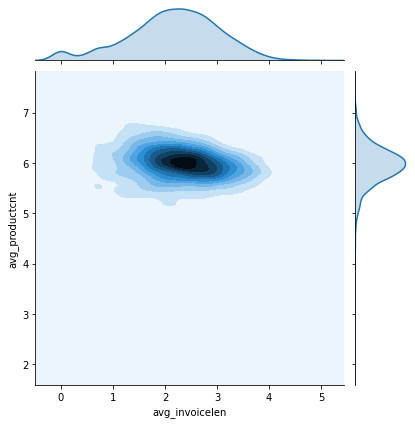

In [ ]:
user_cnt = get_usercnt(data)
user_avgprodcnt = get_user_productcnt(data)
user_avglen = get_user_invoicelen(data, metric = 'avg_invoicelen')
tmp = pd.merge(user_cnt, pd.merge(user_avglen, user_avgprodcnt, on='CustomerID'), on='CustomerID')
print (tmp.head())

snb.jointplot(x=np.log(tmp.user_cnt+1e-10), y=np.log(tmp.avg_invoicelen+1e-10), kind='kde')
plt.show()

snb.jointplot(x=np.log(tmp.user_cnt+1e-10), y=np.log(tmp.avg_productcnt+1e-10), kind='kde')
plt.show()

snb.jointplot(x=np.log(tmp.avg_invoicelen+1e-10), y=np.log(tmp.avg_productcnt+1e-10), kind='kde')
plt.show()

- **Relationship between Purchased times of users and products**: No special pattern

  InvoiceNo StockCode CustomerID  product_cnt  user_cnt
0    563709     22152      15472          108        66
1    567183     22152      14769          108       999
2    573362     22152      12597          108       180
3    561389     22152      12971          108       309
4    569236     22152      14432          108       323


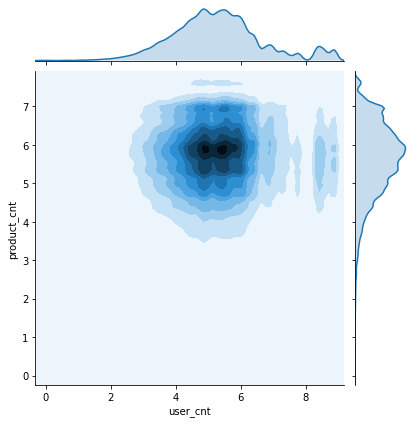

In [ ]:
product_cnt = get_productcnt(data)
user_cnt = get_usercnt(data)

product_key, user_key, pur_key = ['StockCode'], ['CustomerID'], ['InvoiceNo', 'StockCode', 'CustomerID']
tmp = data[pur_key].drop_duplicates()
tmp2 = pd.merge(pd.merge(tmp, product_cnt, on=product_key), pd.merge(tmp, user_cnt, on = user_key), on=pur_key)
print (tmp2.head())

snb.jointplot(x=np.log(tmp2.user_cnt+1e-10), y=np.log(tmp2.product_cnt+1e-10), kind='kde')
plt.show()

- **Relationship between Purchased times of products and average product_cnt of users: No special pattern**

  InvoiceNo StockCode CustomerID  product_cnt  avg_productcnt
0    563709     22152      15472          109      339.860465
1    567183     22152      14769          109      331.918750
2    573362     22152      12597          109      326.770492
3    561389     22152      12971          109      311.206897
4    569236     22152      14432          109      266.833333


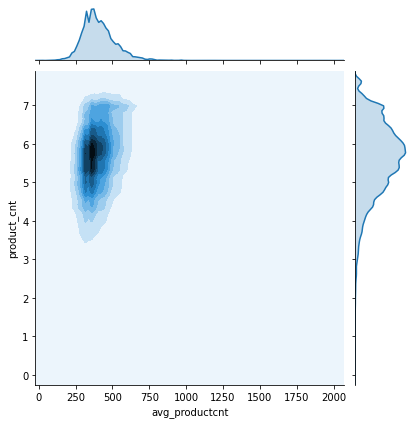

In [ ]:
product_cnt = get_productcnt(data)
user_avgprodcnt = get_user_productcnt(data)

product_key, user_key, pur_key = ['StockCode'], ['CustomerID'], ['InvoiceNo', 'StockCode', 'CustomerID']
tmp = data[pur_key].drop_duplicates()
tmp2 = pd.merge(pd.merge(tmp, product_cnt, on=product_key), pd.merge(tmp, user_avgprodcnt, on = user_key), on=pur_key)
print (tmp2.head())

snb.jointplot(x=tmp2.avg_productcnt, y=np.log(tmp2.product_cnt+1e-10), kind='kde')
plt.show()

  InvoiceNo StockCode CustomerID  product_cnt  avg_productcnt
0    563709     22152      15472          109      339.860465
1    567183     22152      14769          109      331.918750
2    573362     22152      12597          109      326.770492
3    561389     22152      12971          109      311.206897
4    569236     22152      14432          109      266.833333


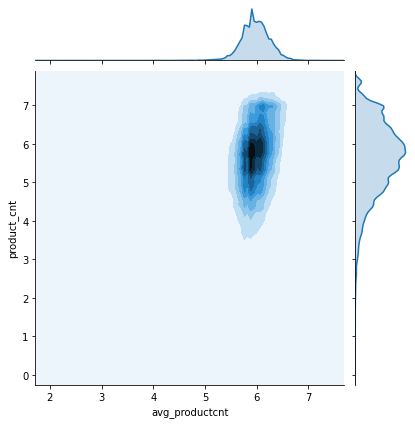

In [ ]:
product_cnt = product_cnt = get_productcnt(data)
user_avglen = get_user_productcnt(data)

product_key, user_key, pur_key = ['StockCode'], ['CustomerID'], ['InvoiceNo', 'StockCode', 'CustomerID']
tmp = data[pur_key].drop_duplicates()
tmp2 = pd.merge(pd.merge(tmp, product_cnt, on=product_key), pd.merge(tmp, user_avglen, on = user_key), on=pur_key)
print (tmp2.head())

snb.jointplot(x=np.log(tmp2.avg_productcnt), y=np.log(tmp2.product_cnt+1e-10), kind='kde')
plt.show()

- **Relationship between Purchased times of products and average invoice length of users**: No special pattern

  InvoiceNo StockCode CustomerID  product_cnt  avg_invoicelen
0    563709     22152      15472          108       43.000000
1    567183     22152      14769          108       63.700000
2    573362     22152      12597          108       24.400000
3    561389     22152      12971          108        2.416667
4    569236     22152      14432          108       33.833333


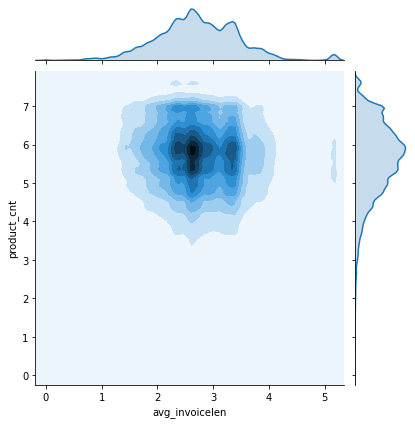

In [ ]:
product_cnt = product_cnt = get_productcnt(data)
user_avglen = get_user_invoicelen(data, metric = 'avg_invoicelen')

product_key, user_key, pur_key = ['StockCode'], ['CustomerID'], ['InvoiceNo', 'StockCode', 'CustomerID']
tmp = data[pur_key].drop_duplicates()
tmp2 = pd.merge(pd.merge(tmp, product_cnt, on=product_key), pd.merge(tmp, user_avglen, on = user_key), on=pur_key)
print (tmp2.head())

snb.jointplot(x=np.log(tmp2.avg_invoicelen+1e-10), y=np.log(tmp2.product_cnt+1e-10), kind='kde')
plt.show()

## 2.2 Analyze Features
- Country
- Quantity and UnitPrice

### Analysis difference between countries

- There are 38 countries.
- The UK is dominant in the log data, takes 445901 lines, respectively 92.21% data. It also has the highest number of distinct products.

=> No need to separate training and testing with different countries

Country:  38


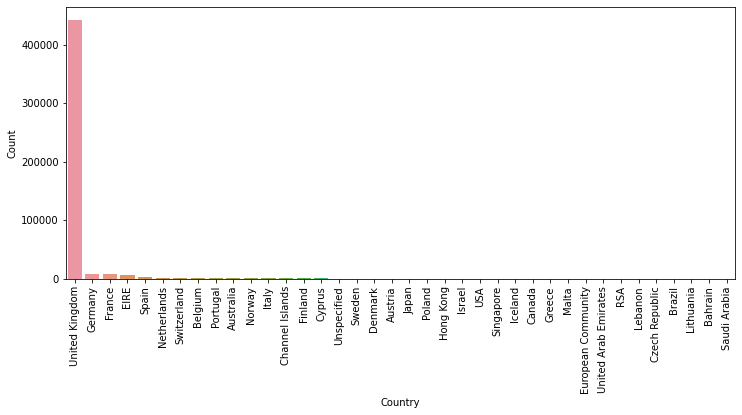

In [ ]:
print ('Country: ', data['Country'].nunique())
metric = 'Count'
tmp = data.Country.value_counts().reset_index(name=metric).rename(columns={'index':'Country'}).sort_values(by=[metric], ascending=[0])

plt.figure(figsize=(12, 5))
snb.barplot(x = tmp.Country, y = tmp[metric])
plt.xticks(rotation=90)
plt.show()

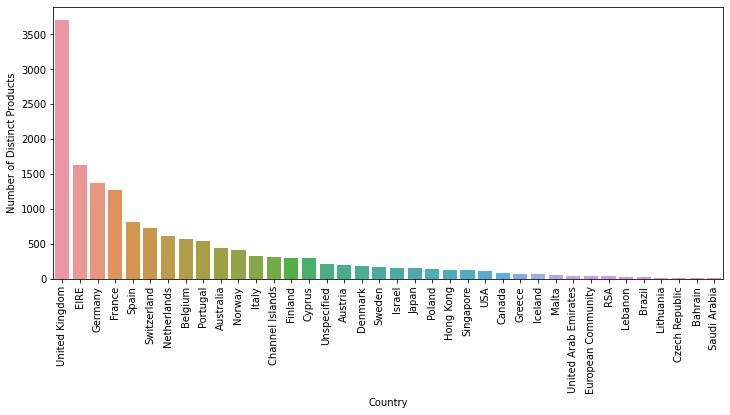

In [ ]:
plt.figure(figsize=(12, 5))
metric = 'Number of Distinct Products'
stock_country=data.groupby(['Country'])['StockCode'].nunique().reset_index(name = metric).sort_values(by = metric, ascending =0)
snb.barplot(x=stock_country.Country, y=stock_country[metric])
plt.xticks(rotation=90)
plt.show()

- **Many countries have stable unit prices, but others have a wider range of variation between products**

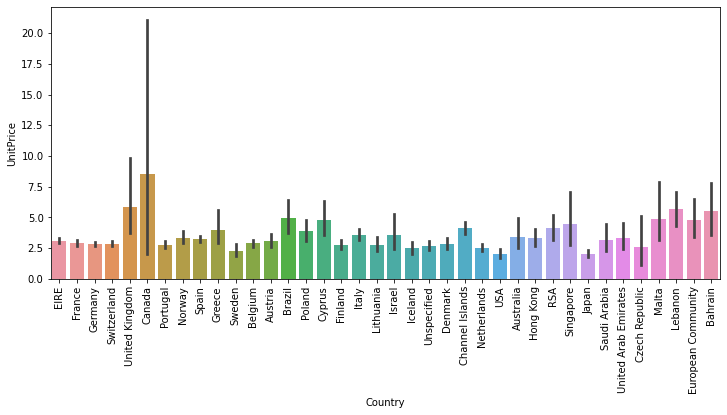

In [ ]:
plt.figure(figsize=(12,5))
tmp = data[data.UnitPrice>0]
stock_up_bycountry = tmp.groupby(['StockCode', 'Country'])['UnitPrice'].mean().reset_index()
snb.barplot(x=stock_up_bycountry.Country, y=stock_up_bycountry.UnitPrice)
plt.xticks(rotation=90)
plt.show()

- **Many countries have stable quantity, comparing between products. Larger mean has larger variation.**
- **A few countries have very high mean of quantity.**

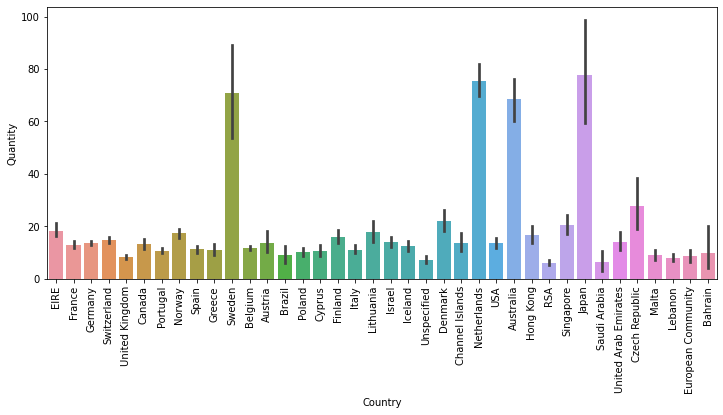

In [ ]:
plt.figure(figsize=(12,5))
tmp = data[data.Quantity>0]
stock_up_bycountry = tmp.groupby(['StockCode', 'Country'])['Quantity'].mean().reset_index()
snb.barplot(x=stock_up_bycountry.Country, y=stock_up_bycountry.Quantity)
plt.xticks(rotation=90)
plt.show()

### Quantity and UnitPrice

- **Distribution of quantity and unitprice**

In [ ]:
data[['Quantity', 'UnitPrice']].describe()

Quantity      UnitPrice
count  483574.000000  483574.000000
mean        9.582304       4.350142
std       114.010007      80.151985
min    -74215.000000       0.000000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max      4800.000000   17836.460000

- **Both of them has high rate of valid values.**

Visualization of their histogram in log transformation is easier to observe.

Quantity
+ Rate Valid values (>0):  0.9835681819121789
+ Histogram of positive values


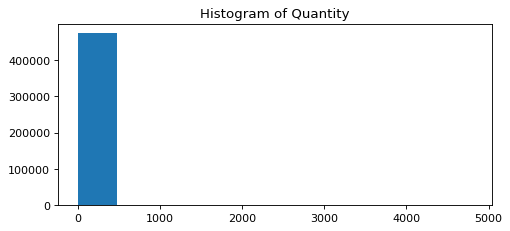

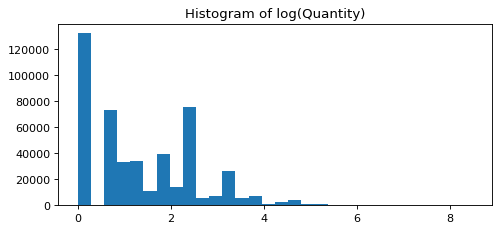

UnitPrice
+ Rate Valid values (>0):  0.9992617469094699
+ Histogram of positive values


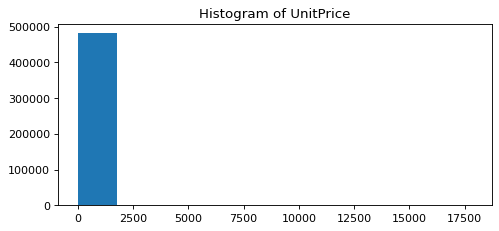

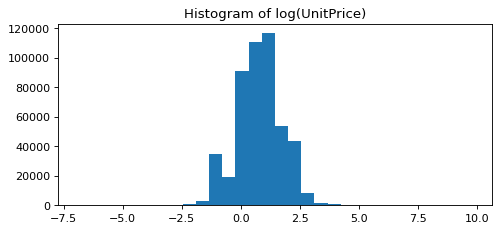

In [ ]:
for c in ['Quantity', 'UnitPrice']:
    print (c)
    print ('+ Rate Valid values (>0): ', len(data[data[c]>0])*1.0/len(data))
    print ('+ Histogram of positive values')
    plt.figure(figsize=(7,3), dpi=80)
    plt.hist(data[data[c]>0][c], bins=10)
    plt.title('Histogram of %s' %c)
    plt.show()
    plt.figure(figsize=(7,3), dpi=80)
    plt.hist(np.log(data[data[c]>0][c]), bins = 30)
    plt.title('Histogram of log(%s)' %c)
    plt.show()

- **Considering in total log, purchases with higher unitprice tend to have less quantity**

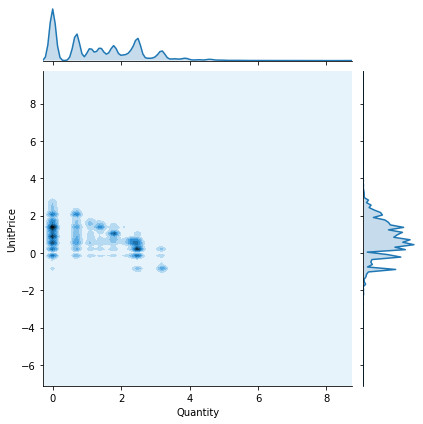

In [ ]:
tmp = data[(data.UnitPrice>0) & (data.Quantity>0)][['Quantity', 'UnitPrice']]
snb.jointplot(x=np.log(tmp.Quantity+1e-10), y=np.log(tmp.UnitPrice+1e-10), kind='kde')
plt.show()

- **In detail, considering the pairs quantity and unitprice of stockcode/users/invoices, it is clearly to see that higher unitprice and lower quantity.**

- mean_quantity of StockCode vs mean_unitprice of Stockcode

  StockCode  mean_quantity  mean_unitprice
0     10002      13.794118        1.074118
1     10080      10.444444        0.441111
2     10120       6.200000        0.210000
3    10123C       1.000000        0.650000
4    10124A       2.800000        0.420000
mean_quantity and mean_unitprice of StockCode after applying log Transformation


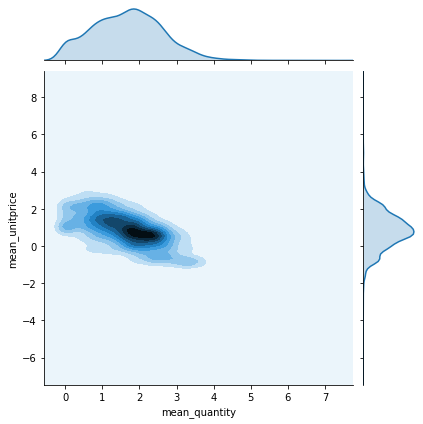

In [ ]:
compare_upvsquan(data, 'StockCode')

- mean_quantity of Invoices vs mean_unitprice of Invoices

  InvoiceNo  mean_quantity  mean_unitprice
0    536365       6.285714        3.058571
1    536366       6.000000        1.850000
2    536367       6.071429        5.031429
3    536368       4.000000        4.716667
4    536369       3.000000        5.950000
mean_quantity and mean_unitprice of InvoiceNo after applying log Transformation


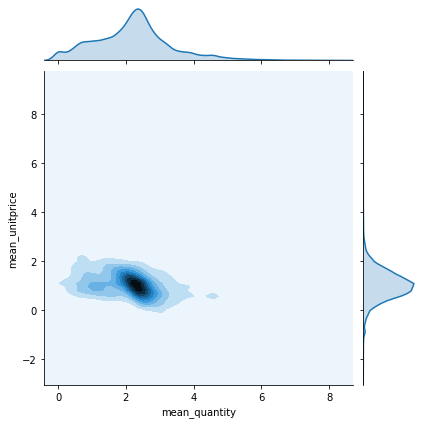

In [ ]:
compare_upvsquan(data, 'InvoiceNo')

- mean_quantity of Users vs mean_unitprice of Users

  CustomerID  mean_quantity  mean_unitprice
0      12347      12.930556        2.561875
1      12348     100.837838        2.650270
2      12349       7.611111        9.572037
3      12350      10.076923        4.607692
4      12352       6.607143        6.004464
mean_quantity and mean_unitprice of CustomerID after applying log Transformation


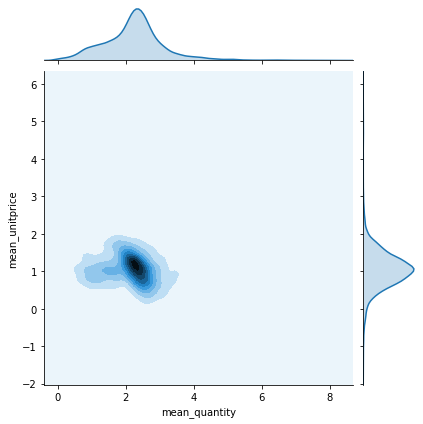

In [ ]:
compare_upvsquan(data, 'CustomerID')

- **Visualize relationship with aspects of stocks**: Stock with higher purchasing times have higher mean_quantiy

  StockCode  product_cnt  mean_quantity  mean_unitprice
0    85123A         2044      14.489630        3.133896
1     22423         2027       6.720872       13.943688
2    85099B         1873      23.248564        2.491157
3     20725         1490      11.678161        2.091212
4     47566         1468      11.281217        5.792497


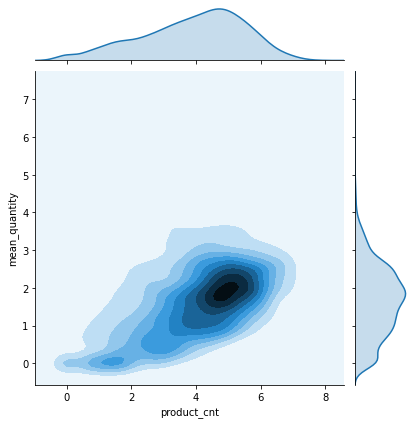

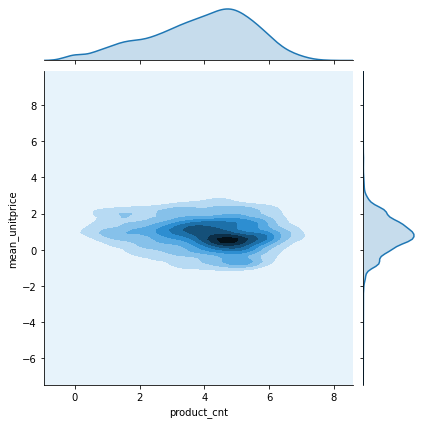

In [ ]:
product_cnt = get_productcnt(data)
product_key, tmp_key = ['StockCode'], ['InvoiceNo', 'Quantity', 'UnitPrice', 'StockCode']

tmp = data[(pd.isnull(data['StockCode'])==False) & (data.UnitPrice>0) & (data.Quantity>0)][tmp_key].drop_duplicates()
stock_quan = tmp.groupby(['StockCode'])['Quantity'].mean().reset_index(name='mean_quantity')
stock_up = tmp.groupby(['StockCode'])['UnitPrice'].mean().reset_index(name='mean_unitprice')

tmp2 = pd.merge(product_cnt, pd.merge(stock_quan, stock_up, on=product_key) )
print (tmp2.head())

snb.jointplot(x=np.log(tmp2.product_cnt+1e-10), y=np.log(tmp2.mean_quantity+1e-10), kind='kde')
plt.show()

snb.jointplot(x=np.log(tmp2.product_cnt+1e-10), y=np.log(tmp2.mean_unitprice+1e-10), kind='kde')
plt.show()

- **Visualize relationship with aspects of users**: no speicial pattern


    - mean_quantity of users vs user_cnt
    - mean_unitprice of users vs user_cnt


  CustomerID  user_cnt  mean_quantity  mean_unitprice
0      17841      2958       3.627451        2.862184
1      14911      2389      15.065299        4.505626
2      12748      1892       6.226744        2.555936
3      14606      1195       2.796653        3.061113
4      15311      1120      15.695536        2.604652


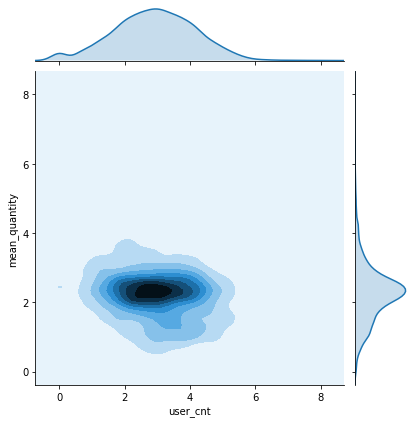

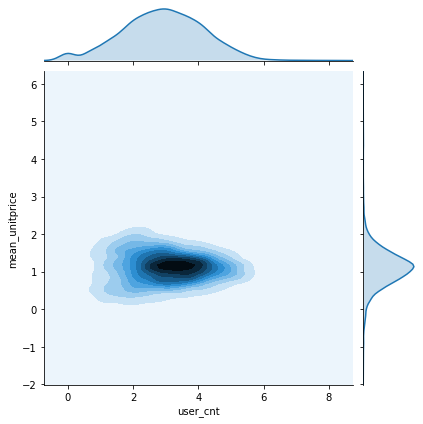

In [ ]:
user_cnt = get_usercnt(data)
user_key, tmp_key = ['CustomerID'], ['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID']

tmp = data[(pd.isnull(data['CustomerID'])==False) & (data.UnitPrice>0) & (data.Quantity>0)][tmp_key].drop_duplicates()
user_quan = tmp.groupby(['CustomerID'])['Quantity'].mean().reset_index(name='mean_quantity')
user_up = tmp.groupby(['CustomerID'])['UnitPrice'].mean().reset_index(name='mean_unitprice')

tmp2 = pd.merge(user_cnt, pd.merge(user_quan, user_up, on=user_key) )
print (tmp2.head())

snb.jointplot(x=np.log(tmp2.user_cnt+1e-10), y=np.log(tmp2.mean_quantity+1e-10), kind='kde')
plt.show()

snb.jointplot(x=np.log(tmp2.user_cnt+1e-10), y=np.log(tmp2.mean_unitprice+1e-10), kind='kde')
plt.show()

    - mean_quantity of users vs user_cnt
    - mean_unitprice of users vs user_cnt

['InvoiceNo', 'StockCode', 'CustomerID', 'UnitPrice', 'Quantity']
  CustomerID  avg_productcnt  mean_quantity  mean_unitprice
0      12347      379.041237      12.690722        2.627629
1      12348      417.062500      81.117647        5.272353
2      12349      452.617647       8.176471       12.848529
3      12350      369.400000      10.100000        5.400000
4      12352      461.487805       5.916667       24.243056


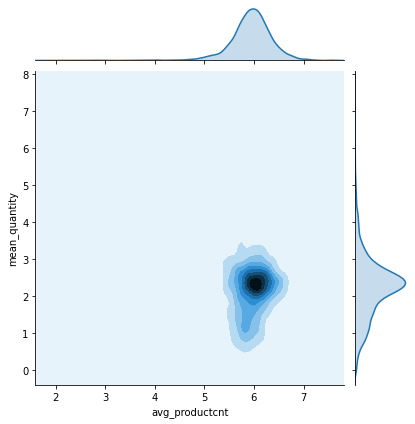

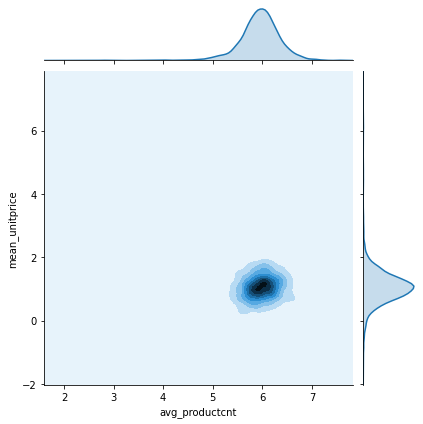

In [ ]:
user_productcnt = get_user_productcnt(data)
tmp = data[(pd.isnull(data['CustomerID'])==False) & (data.UnitPrice>0) & (data.Quantity>0)][full_key].drop_duplicates()

user_quan = tmp.groupby(['CustomerID'])['Quantity'].mean().reset_index(name='mean_quantity')
user_up = tmp.groupby(['CustomerID'])['UnitPrice'].mean().reset_index(name='mean_unitprice')

tmp2 = pd.merge(user_productcnt, pd.merge(user_quan, user_up, on=user_key) )
print (tmp2.head())

snb.jointplot(x=np.log(tmp2.avg_productcnt+1e-10), y=np.log(tmp2.mean_quantity+1e-10), kind='kde')
plt.show()

snb.jointplot(x=np.log(tmp2.avg_productcnt+1e-10), y=np.log(tmp2.mean_unitprice+1e-10), kind='kde')
plt.show()

    - mean_quantity of users vs avglen of users
    - mean_unitprice of users vs avglen of users


  CustomerID     avglen  mean_quantity  mean_unitprice
0      12347  13.857143      13.300000        2.724143
1      12348   4.000000      63.615385        6.795385
2      12349  34.000000       7.892857       15.026786
3      12350  10.000000       9.625000        6.387500
4      12352   4.875000       6.666667        6.313333


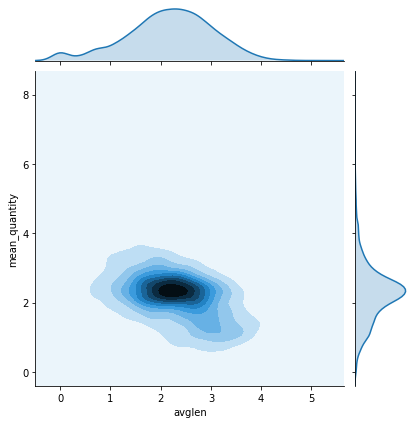

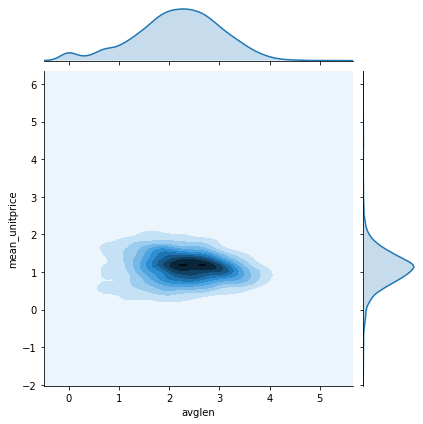

In [ ]:
user_avglen = get_user_invoicelen(data, metrc='avg_invlen')
tmp = data[(pd.isnull(data['CustomerID'])==False) & (data.UnitPrice>0) & (data.Quantity>0)][full_key].drop_duplicates()
user_quan = tmp.groupby(['CustomerID'])['Quantity'].mean().reset_index(name='mean_quantity')
user_up = tmp.groupby(['CustomerID'])['UnitPrice'].mean().reset_index(name='mean_unitprice')

user_key, full_key = ['CustomerID'], ['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID']
tmp2 = pd.merge(user_avglen, pd.merge(user_quan, user_up, on=user_key) )
print (tmp2.head())

snb.jointplot(x=np.log(tmp2.avg_invlen+1e-10), y=np.log(tmp2.mean_quantity+1e-10), kind='kde')
plt.show()

snb.jointplot(x=np.log(tmp2.avg_invlen+1e-10), y=np.log(tmp2.mean_unitprice+1e-10), kind='kde')
plt.show()

---

# **3. Pre-processing and feature extraction for products with NLP**

3.1 Preparation
- Pre-processing Stock and Description
- Prepare for LDA

3.2 Applying LDA:

- Extract topics for products

- Analyze topics vs purchases products and users


Output variables:

- **product_prob**: a numpy matrix show probabilities of each product belong to clusters:
    - Extract matrix: check
    
    - **Grouping products**: notopic_product, lowprob_product, midprob_product, highprob_product

    - Visualization: check

- **product_df**: DataFrame(StockCode, Description, Topic Info)


## 3.1 Preparation

### ***Functions***

In [ ]:
import re

from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import tokenize
from gensim import corpora

from gensim.models import ldamodel, CoherenceModel

import matplotlib.colors as mcolors
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

     |████████████████████████████████| 1.6MB 8.3MB/s 
     |████████████████████████████████| 552kB 47.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=b2c8bf0a8ca6332a8ab725090f2372e1f2769ca00858a6a7dab871c1d0f14d31
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=a39adf7fca2bad3ace750a650317c18e0245fad318ed7e14c76fa93b11387710
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
def create_mapping(list1, list2):
	return dict(zip(list1, list2))
def convert_mapping(mapping, encode_list):
	return list(map(lambda x: mapping[x], encode_list))

def prepare_mapping(product_lists):
    id2word = corpora.Dictionary(product_lists)
    corpus = [id2word.doc2bow(w) for w in product_lists]
    # all_products = np.array([item[1] for item in id2word.items()])
    return id2word, corpus

def get_lda_topics(model, num_topics, stock2dec_mapping):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Topic #' + '{:02d}'.format(i+1)] = convert_mapping(stock2dec_mapping,[i[0] for i in words]);
    return pd.DataFrame(word_dict)

In [ ]:
def evaluate_model(lda_model):
    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
    # Compute Coherence Score
    # coherence_model_lda = CoherenceModel(model=lda_model, texts=data.products, dictionary=id2word, coherence='c_v')
    # coherence_lda = coherence_model_lda.get_coherence()
    # print('\nCoherence Score: ', coherence_lda)

def visualize_topics(lda_model, stop_words, num_topics, stock2dec_mapping, ncol=4):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    cols = cols + cols
    cloud = WordCloud(stopwords=stop_words,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=20,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i%8],
                    prefer_horizontal=1.0)
    topics = lda_model.show_topics(num_topics=num_topics, formatted=False)
    nrow= int((int(num_topics-1)/ncol)+1)
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 12), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words_tmp = dict(topics[i][1])
        keys, values = list(topic_words_tmp.keys()), list(topic_words_tmp.values())
        topic_words = dict(zip(convert_mapping(stock2dec_mapping,keys),values))
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

def visualize_topics_withprob(products_prob, np_productset, ncol=8):
    print ('Milestones -20, -10 correspondingly are: ', np.exp(-20), np.exp(-10))
    nrow= int((int(num_topics-1)/ncol)+1)
    fig, axes = plt.subplots(nrow, ncol, figsize=(18, 6), sharex=True, sharey=True)
    for t, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        plt.hist(np.log(products_prob[np_productset, t]+1e-10))
        plt.gca().set_title('topic ' + str(t), fontdict=dict(size=10))
    plt.show()

### Clean stock and description

In [ ]:
print ('Number of unique StockCode and Description')
print (' + Data full: ')
print (data_full[['StockCode','Description']].nunique().reset_index(name='Unique Count').rename(columns={'index':'field'}))
print ('\n + Training data: ')
print (data[['StockCode','Description']].nunique().reset_index(name='Unique Count').rename(columns={'index':'field'}))

Number of unique StockCode and Description
 + Data full: 
         field  Unique Count
0    StockCode          4070
1  Description          4223

 + Training data: 
         field  Unique Count
0    StockCode          3923
1  Description          4036


#### Cases

In [ ]:
data[data.StockCode.isin(['85184C', '84558A', '84558a'])][['StockCode', 'Description']].drop_duplicates().sort_values(by='StockCode')

StockCode                          Description
887       84558A         3D DOG PICTURE PLAYING CARDS
16223     84558a         3D DOG PICTURE PLAYING CARDS
23090     85184C    S/4 VALENTINE DECOUPAGE HEART BOX
208806    85184C  SET 4 VALENTINE DECOUPAGE HEART BOX

In [ ]:
data[data.Description == '3D DOG PICTURE PLAYING CARDS'].StockCode.unique()

<StringArray>
['84558A', '84558a']
Length: 2, dtype: string

In [ ]:
data[data.StockCode=='85184C'].Description.unique()

<StringArray>
['SET 4 VALENTINE DECOUPAGE HEART BOX', 'S/4 VALENTINE DECOUPAGE HEART BOX']
Length: 2, dtype: string

#### ***Processing***

In [ ]:
data['StockCode']=data['StockCode'].apply(lambda r: r.upper())
data['Invalid_Description'] = data['Description'].apply(lambda r: r.isupper()==False if pd.isnull(r)==False else True)
data = data[data.Invalid_Description==False]
del data['Invalid_Description']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
product_id = data[['StockCode', 'Description']].drop_duplicates(subset='StockCode')
print (len(product_id))
product_id.head()

3696


StockCode                    Description
7      22633         HAND WARMER UNION JACK
8      22632      HAND WARMER RED POLKA DOT
9      84879  ASSORTED COLOUR BIRD ORNAMENT
10     22745     POPPY'S PLAYHOUSE BEDROOM 
11     22748      POPPY'S PLAYHOUSE KITCHEN

### ***Prepare for LDA***

In [ ]:
stock2dec_mapping = create_mapping(product_id.StockCode, product_id.Description)

In [ ]:
invoice_aslist = data.groupby(['InvoiceNo'])['StockCode'].apply(list)
invoice_aslist = invoice_aslist.reset_index(name='Products').rename(columns={'index':'Invoice'})
invoice_aslist.head()

InvoiceNo                                           Products
0    536366                                     [22633, 22632]
1    536367  [84879, 22745, 22748, 22749, 22310, 84969, 226...
2    536370  [22728, 22727, 22726, 21724, 21883, 10002, 217...
3    536374                                            [21258]
4    536375  [85123A, 71053, 84406B, 20679, 37370, 21871, 2...

In [ ]:
id2word, corpus = prepare_mapping(invoice_aslist.Products)
del invoice_aslist

## 3.2 Applying LDA

### ***3.2.1 LDA(16)***

In [ ]:
num_topics = 16
lda_16 = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize=1000)

In [ ]:
lda_vis_df = get_lda_topics(lda_16, num_topics, stock2dec_mapping)
lda_vis_df.head()

Topic #01  ...                      Topic #16
0           KEY FOB , BACK DOOR   ...         HAND WARMER OWL DESIGN
1                 KEY FOB , SHED  ...  DOORMAT KEEP CALM AND COME IN
2     MAGNETS PACK OF 4 SWALLOWS  ...         HAND WARMER UNION JACK
3        KEY FOB , GARAGE DESIGN  ...     HOT WATER BOTTLE KEEP CALM
4  36 PENCILS TUBE RED RETROSPOT  ...     HAND WARMER RED LOVE HEART

[5 rows x 16 columns]

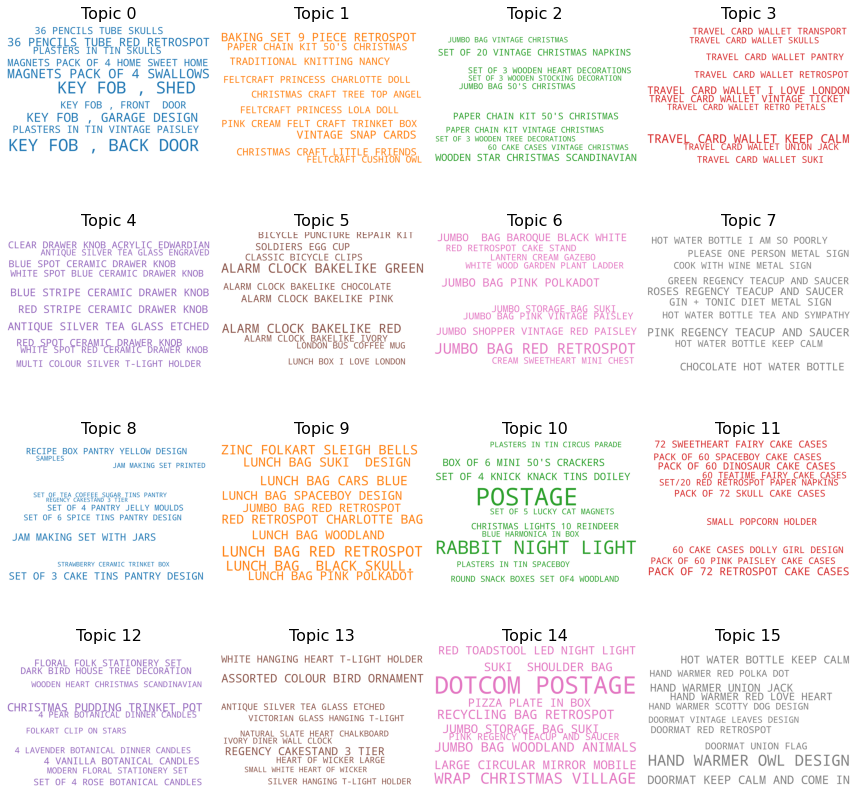

In [ ]:
visualize_topics(lda_16, stopwords, num_topics=16, stock2dec_mapping=stock2dec_mapping, ncol=4)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_16, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.074574  0.104284       1        1  10.555292
2     -0.070603  0.016940       2        1   7.874304
14     0.169152  0.099467       3        1   7.861392
1     -0.198400 -0.004089       4        1   7.578172
12     0.128246  0.196072       5        1   7.470318
7      0.026268 -0.085283       6        1   6.833539
13     0.075756 -0.236902       7        1   6.524862
6      0.172533 -0.053987       8        1   5.661582
0      0.026871  0.009263       9        1   5.546249
8     -0.014479 -0.067376      10        1   5.508758
10    -0.235061  0.009517      11        1   5.386338
11    -0.105967  0.080793      12        1   5.356831
3      0.102500  0.179336      13        1   5.156309
15    -0.008031 -0.171098      14        1   4.390900
5     -0.143784  0.010164      15        1   4.321631
4      0.149573 -0.087100      16        1   3.973521, topic_info=        Term         Freq        Total Category  logprob  loglift
33      POST   834.000000   834.000000  Default  30.0000  30.0000
126   85099B  1376.000000  1376.000000  Default  29.0000  29.0000
1448   35970   576.000000   576.000000  Default  28.0000  28.0000
123    22960   851.000000   851.000000  Default  27.0000  27.0000
2217   22720   984.000000   984.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1963   22460    72.106583   165.166824  Topic16  -5.1507   2.3967
200    22178    92.236877   576.364380  Topic16  -4.9045   1.3931
118    84755    79.051262   266.713440  Topic16  -5.0588   2.0094
1382   47566    87.649467   678.456848  Topic16  -4.9555   1.1790
1268   22983    74.340118   232.541855  Topic16  -5.1202   2.0851

[1021 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1370      6  0.060011  10120
1370     11  0.840161  10120
528       3  0.018712  11001
528       9  0.018712  11001
528      12  0.935617  11001
...     ...       ...    ...
33       13  0.002397   POST
33       14  0.005992   POST
33       15  0.035953   POST
33       16  0.001198   POST
3611     10  0.992370      S

[6095 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 15, 2, 13, 8, 14, 7, 1, 9, 11, 12, 4, 16, 6, 5])

### Other values of num_topics

##### LDA(16)

In [ ]:
num_topics = 16
lda_16 = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize=1000)

In [ ]:
lda_vis_df = get_lda_topics(lda_16, num_topics, stock2dec_mapping)
lda_vis_df.head()

Topic #01  ...                      Topic #16
0           KEY FOB , BACK DOOR   ...         HAND WARMER OWL DESIGN
1                 KEY FOB , SHED  ...  DOORMAT KEEP CALM AND COME IN
2     MAGNETS PACK OF 4 SWALLOWS  ...         HAND WARMER UNION JACK
3        KEY FOB , GARAGE DESIGN  ...     HOT WATER BOTTLE KEEP CALM
4  36 PENCILS TUBE RED RETROSPOT  ...     HAND WARMER RED LOVE HEART

[5 rows x 16 columns]

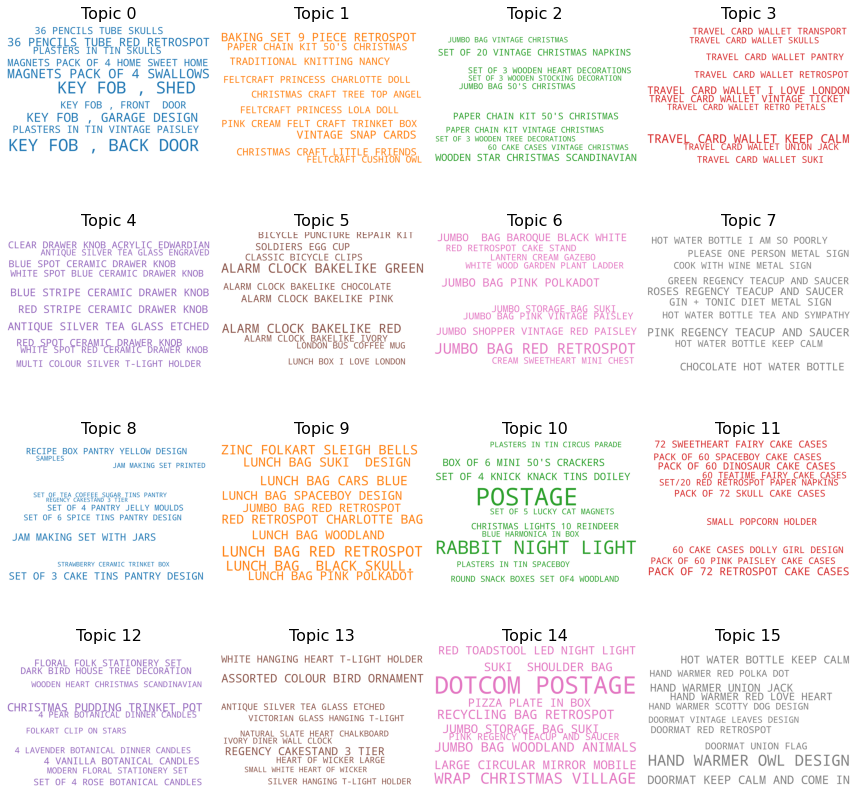

In [ ]:
visualize_topics(lda_16, stopwords, num_topics=16, stock2dec_mapping=stock2dec_mapping, ncol=4)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_16, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.074574  0.104284       1        1  10.555292
2     -0.070603  0.016940       2        1   7.874304
14     0.169152  0.099467       3        1   7.861392
1     -0.198400 -0.004089       4        1   7.578172
12     0.128246  0.196072       5        1   7.470318
7      0.026268 -0.085283       6        1   6.833539
13     0.075756 -0.236902       7        1   6.524862
6      0.172533 -0.053987       8        1   5.661582
0      0.026871  0.009263       9        1   5.546249
8     -0.014479 -0.067376      10        1   5.508758
10    -0.235061  0.009517      11        1   5.386338
11    -0.105967  0.080793      12        1   5.356831
3      0.102500  0.179336      13        1   5.156309
15    -0.008031 -0.171098      14        1   4.390900
5     -0.143784  0.010164      15        1   4.321631
4      0.149573 -0.087100      16        1   3.973521, topic_info=        Term         Freq        Total Category  logprob  loglift
33      POST   834.000000   834.000000  Default  30.0000  30.0000
126   85099B  1376.000000  1376.000000  Default  29.0000  29.0000
1448   35970   576.000000   576.000000  Default  28.0000  28.0000
123    22960   851.000000   851.000000  Default  27.0000  27.0000
2217   22720   984.000000   984.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1963   22460    72.106583   165.166824  Topic16  -5.1507   2.3967
200    22178    92.236877   576.364380  Topic16  -4.9045   1.3931
118    84755    79.051262   266.713440  Topic16  -5.0588   2.0094
1382   47566    87.649467   678.456848  Topic16  -4.9555   1.1790
1268   22983    74.340118   232.541855  Topic16  -5.1202   2.0851

[1021 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1370      6  0.060011  10120
1370     11  0.840161  10120
528       3  0.018712  11001
528       9  0.018712  11001
528      12  0.935617  11001
...     ...       ...    ...
33       13  0.002397   POST
33       14  0.005992   POST
33       15  0.035953   POST
33       16  0.001198   POST
3611     10  0.992370      S

[6095 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 15, 2, 13, 8, 14, 7, 1, 9, 11, 12, 4, 16, 6, 5])

##### LDA(12)

In [ ]:
num_topics = 12
lda_12 = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize=200)

In [ ]:
lda_vis_df = get_lda_topics(lda_12, num_topics, stock2dec_mapping)
lda_vis_df.head()

Topic #01  ...                        Topic #12
0  WHITE HANGING HEART T-LIGHT HOLDER  ...                          POSTAGE
1    RED HANGING HEART T-LIGHT HOLDER  ...               RABBIT NIGHT LIGHT
2   GARDENERS KNEELING PAD KEEP CALM   ...  VICTORIAN GLASS HANGING T-LIGHT
3   WOODEN PICTURE FRAME WHITE FINISH  ...    BAKING SET 9 PIECE RETROSPOT 
4         WOODEN FRAME ANTIQUE WHITE   ...     ANTIQUE SILVER T-LIGHT GLASS

[5 rows x 12 columns]

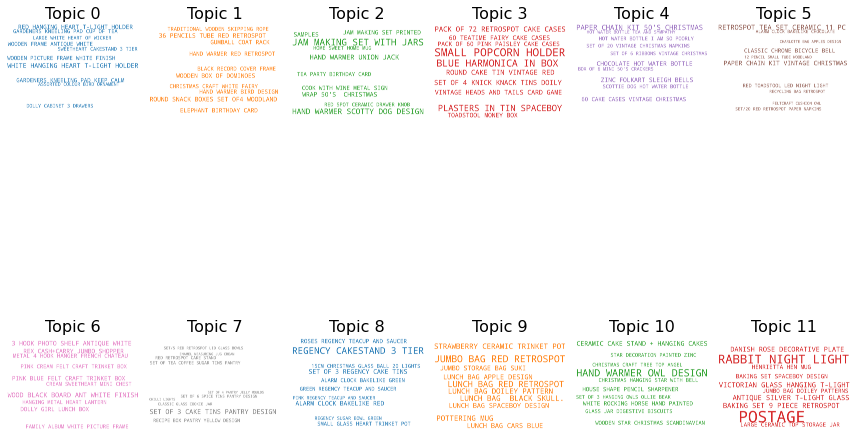

In [ ]:
visualize_topics(lda_12, stopwords, num_topics=12, stock2dec_mapping=stock2dec_mapping, n_col=6)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_12, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.039658 -0.175320       1        1  11.891543
3     -0.228269  0.081192       2        1  10.807847
10    -0.018573 -0.251273       3        1  10.542144
0      0.261929 -0.040954       4        1   8.618067
6      0.088676 -0.130743       5        1   8.570825
4     -0.034344 -0.069448       6        1   7.701669
1     -0.167955  0.107369       7        1   7.618692
5     -0.200465  0.013385       8        1   7.416564
7      0.052754  0.183791       9        1   7.064093
8      0.150819  0.237784      10        1   6.975831
2      0.017016  0.031795      11        1   6.467006
11     0.118070  0.012422      12        1   6.325724, topic_info=        Term         Freq        Total Category  logprob  loglift
382    22423  3362.000000  3362.000000  Default  30.0000  30.0000
2268   22720  1956.000000  1956.000000  Default  29.0000  29.0000
189     POST  1638.000000  1638.000000  Default  28.0000  28.0000
252   85099B  2048.000000  2048.000000  Default  27.0000  27.0000
64     22139  1469.000000  1469.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
3095   23080   298.310394   554.259888  Topic12  -4.6303   2.1410
768   84970S   221.404388   279.128662  Topic12  -4.9284   2.5289
2970   23201   270.052124   787.466492  Topic12  -4.7298   1.6903
3623   23582   234.341705   656.783081  Topic12  -4.8716   1.7300
3068   23202   230.944839   641.713684  Topic12  -4.8862   1.7386

[638 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1194      5  0.989289      15036
3342      2  0.025569     16169E
3342      3  0.024149     16169E
3342      6  0.038354     16169E
3342      9  0.001421     16169E
...     ...       ...        ...
1896      8  0.046501  AMAZONFEE
1896      9  0.017132  AMAZONFEE
1896     11  0.930011  AMAZONFEE
189      12  0.998726       POST
3706     11  0.995924          S

[1551 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 11, 1, 7, 5, 2, 6, 8, 9, 3, 12])

##### LDA(8)

In [ ]:
num_topics = 8
lda_8 = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize=200)

In [ ]:
lda_vis_df = get_lda_topics(lda_8, num_topics, stock2dec_mapping)
lda_vis_df.head()

Topic #01  ...                         Topic #08
0    SET OF 3 CAKE TINS PANTRY DESIGN   ...  RETROSPOT TEA SET CERAMIC 11 PC 
1             JAM MAKING SET WITH JARS  ...    STRAWBERRY CERAMIC TRINKET POT
2    GARDENERS KNEELING PAD KEEP CALM   ...                     POTTERING MUG
3         ANTIQUE SILVER T-LIGHT GLASS  ...            HAND WARMER UNION JACK
4  WOODEN HEART CHRISTMAS SCANDINAVIAN  ...     GIN AND TONIC DIET METAL SIGN

[5 rows x 8 columns]

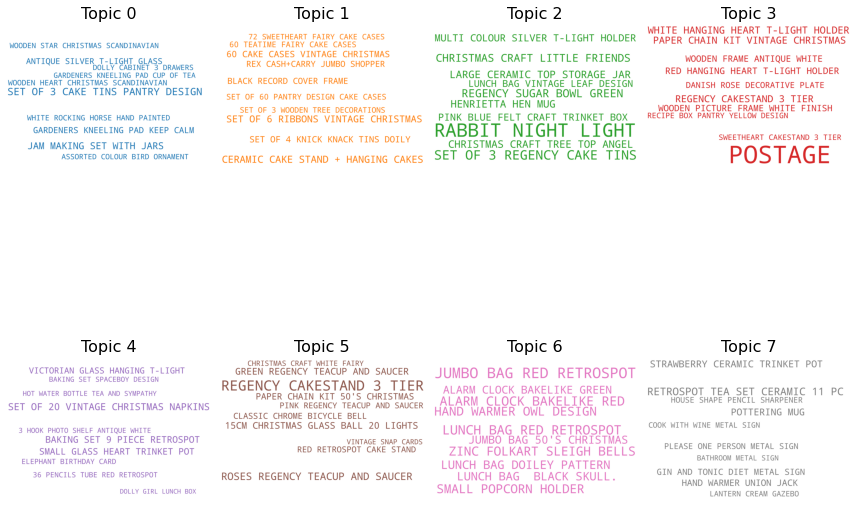

In [ ]:
visualize_topics(lda_8, stopwords, num_topics=8, stock2dec_mapping=stock2dec_mapping, n_col=4)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_8, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.234320  0.163057       1        1  16.388241
4     -0.140118  0.023313       2        1  13.695951
0      0.017521 -0.120819       3        1  13.115115
7      0.260933  0.190935       4        1  13.064772
1     -0.076499  0.011204       5        1  12.637426
5      0.201112  0.082672       6        1  11.302246
3      0.077688 -0.321995       7        1  10.904593
2     -0.106318 -0.028367       8        1   8.891662, topic_info=        Term         Freq        Total Category  logprob  loglift
382    22423  3830.000000  3830.000000  Default  30.0000  30.0000
189     POST  2064.000000  2064.000000  Default  29.0000  29.0000
252   85099B  1820.000000  1820.000000  Default  28.0000  28.0000
64     22139  1229.000000  1229.000000  Default  27.0000  27.0000
451    22699  1138.000000  1138.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
3110   23169   433.592804   690.949707   Topic8  -4.5968   1.9541
3034   23284   404.883301   678.941956   Topic8  -4.6653   1.9031
3081   23170   318.787811   413.342773   Topic8  -4.9044   2.1603
3503   23494   398.961395   691.982849   Topic8  -4.6800   1.8694
22     22326   366.248810   727.918213   Topic8  -4.7656   1.7332

[448 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1194      8  0.985476      15036
1664      6  0.987593      15039
3342      3  0.975476     16169E
3342      4  0.001834     16169E
3342      6  0.018336     16169E
...     ...       ...        ...
1896      7  0.975226  AMAZONFEE
1896      8  0.019284  AMAZONFEE
189       7  0.904309       POST
189       8  0.094935       POST
3706      7  0.996072          S

[1070 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 1, 8, 2, 6, 4, 3])

##### LDA(6)

In [ ]:
num_topics = 6
lda_6 = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize=200)

In [ ]:
lda_vis_df = get_lda_topics(lda_6, num_topics, stock2dec_mapping)
lda_vis_df.head()

Topic #01  ...                          Topic #06
0                              POSTAGE  ...            LUNCH BAG RED RETROSPOT
1             JAM MAKING SET WITH JARS  ...  PAPER CHAIN KIT VINTAGE CHRISTMAS
2     RETROSPOT TEA SET CERAMIC 11 PC   ...               SMALL POPCORN HOLDER
3    GARDENERS KNEELING PAD KEEP CALM   ...     STRAWBERRY CERAMIC TRINKET POT
4  15CM CHRISTMAS GLASS BALL 20 LIGHTS  ...            LUNCH BAG  BLACK SKULL.

[5 rows x 6 columns]

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_6, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.058380  0.211197       1        1  19.489782
2      0.256536 -0.260334       2        1  19.322020
1     -0.123186 -0.117646       3        1  16.252092
3     -0.171109 -0.034501       4        1  15.581677
0     -0.192577  0.001516       5        1  15.480524
5      0.171956  0.199767       6        1  13.873900, topic_info=        Term         Freq        Total Category  logprob  loglift
189     POST  2390.000000  2390.000000  Default  30.0000  30.0000
382    22423  3411.000000  3411.000000  Default  29.0000  29.0000
152    20725  1378.000000  1378.000000  Default  28.0000  28.0000
121    22910  1238.000000  1238.000000  Default  27.0000  27.0000
252   85099B  1485.000000  1485.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
599    21216   451.512970   509.671692   Topic6  -5.0012   1.8540
137    21212   517.297546   832.702881   Topic6  -4.8652   1.4991
1316   47566   492.488525   765.102661   Topic6  -4.9143   1.5346
3624   23583   463.396759   844.325806   Topic6  -4.9752   1.3752
382    22423   445.887146  3411.756104   Topic6  -5.0137  -0.0598

[372 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
54        5  0.985518    15056BL
54        6  0.007916    15056BL
494       5  0.988650     15056N
494       6  0.004433     15056N
3342      2  0.001370     16169E
...     ...       ...        ...
1896      2  0.002402  AMAZONFEE
1896      5  0.019218  AMAZONFEE
1896      6  0.977697  AMAZONFEE
189       5  0.999307       POST
3706      6  0.996435          S

[908 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1, 6])

### 3.2.2 Probability matrix and dataframe shows topics of words

#### ***Extract product_prob***

In [ ]:
minimum_probability = 1e-4
num_topics=16
products_prob = np.zeros((len(product_id), num_topics))
for i in range(len(product_id)):
    topics = lda_16.get_term_topics(product_id.iloc[i].StockCode, minimum_probability=minimum_probability)
    for t in topics:
        products_prob[i, t[0]]=t[1]
for t in range(num_topics):
    print ('Number of products in topics %d:' % t, np.sum(products_prob[:, t]>0))
print ('Number of products with no topics: ', np.sum(np.sum(products_prob, axis=1) == 0))
products_prob.shape

Number of products in topics 0: 885
Number of products in topics 1: 736
Number of products in topics 2: 929
Number of products in topics 3: 952
Number of products in topics 4: 721
Number of products in topics 5: 711
Number of products in topics 6: 679
Number of products in topics 7: 972
Number of products in topics 8: 666
Number of products in topics 9: 616
Number of products in topics 10: 754
Number of products in topics 11: 824
Number of products in topics 12: 1147
Number of products in topics 13: 657
Number of products in topics 14: 893
Number of products in topics 15: 713
Number of products with no topics:  631


(3696, 16)

#### ***Create productprob_df from prob_matrix***

In [ ]:
notopic_product = np.where(np.sum(products_prob, axis=1)==0)[0]
productprob_df = pd.DataFrame()
productprob_df['StockCode'] = product_id.StockCode.unique()
productprob_df['Topic'] = np.argmax(products_prob, axis=1)
productprob_df.loc[notopic_product,'Topic']=16
for i in range(num_topics):
    productprob_df['Topic_%d'%i]=products_prob[:, i]
productprob_df.head()

StockCode  Topic   Topic_0   Topic_1  ...  Topic_12  Topic_13  Topic_14  Topic_15
0     22633     15  0.000000  0.000313  ...  0.000000  0.000000       0.0  0.016362
1     22632     15  0.000100  0.000419  ...  0.000000  0.000000       0.0  0.011898
2     84879     13  0.000951  0.001548  ...  0.000294  0.022365       0.0  0.002112
3     22745     10  0.000000  0.002459  ...  0.000109  0.000000       0.0  0.000000
4     22748     10  0.000000  0.002830  ...  0.000000  0.000000       0.0  0.000000

[5 rows x 18 columns]

## Overview topics on purchases products and users

#### product and users on topics

  InvoiceNo StockCode  Topic
0    536366     22633     15
1    536544     22633     15
2    536629     22633     15
3    536637     22633     15
4    536637     22633     15


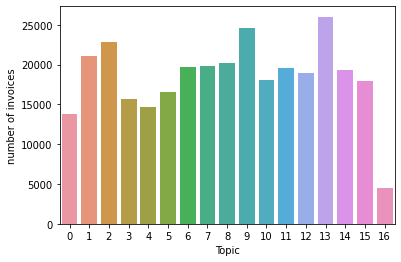

In [ ]:
tmp = pd.merge(data[['InvoiceNo', 'StockCode']], productprob_df[['StockCode', 'Topic']], on='StockCode')
print (tmp.head())
snb.barplot(x='Topic', y ='number of invoices', data=tmp['Topic'].value_counts().reset_index(name='number of invoices').rename(columns={'index':'Topic'}))
plt.show()

  StockCode   SumProb  product_cnt  Topic
0     22633  0.026619          292     15
1     22632  0.018419          232     15
2     84879  0.042361          895     13
3     22745  0.008340          260     10
4     22748  0.010094          277     10


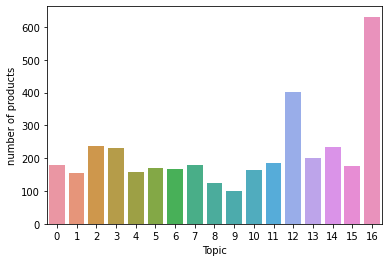

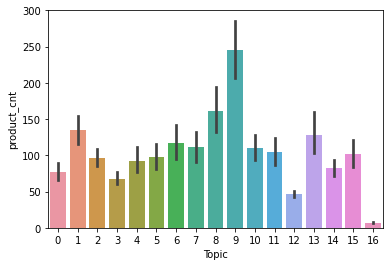

In [ ]:
product_cnt = get_productcnt(data)
product_sumprob = pd.DataFrame({'StockCode':product_id.StockCode, 'SumProb': np.sum(products_prob, axis=1)})
tmp = pd.merge(pd.merge(product_sumprob, product_cnt, on = 'StockCode'), productprob_df[['StockCode', 'Topic']], on='StockCode')
print (tmp.head())
snb.barplot(x='Topic', y ='number of products', data=tmp['Topic'].value_counts().reset_index(name='number of products').rename(columns={'index':'Topic'}))
plt.show()
snb.barplot(x='Topic', y ='product_cnt', data=tmp)
plt.show()

  StockCode CustomerID  user_cnt  avg_productcnt  Topic
0     22633      17850       153      334.143791     15
1     22633      17850       153      334.143791     15
2     22633      17850       153      334.143791     15
3     22633      17850       153      334.143791     15
4     22633      17850       153      334.143791     15


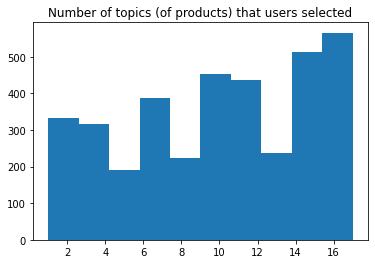

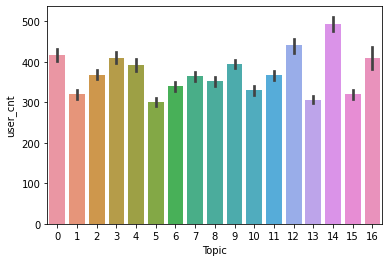

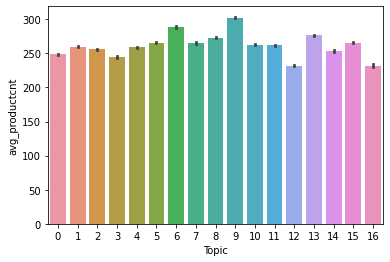

In [ ]:
user_cnt = get_usercnt(data)
user_prodcnt = get_user_productcnt(data)
tmp = pd.merge(pd.merge(data[['StockCode', 'CustomerID']], pd.merge(user_cnt, user_prodcnt)), productprob_df[['StockCode', 'Topic']])
tmp = tmp.dropna()
print (tmp.head())
topiccnt_user = tmp.groupby(['CustomerID']).Topic.nunique().reset_index(name='topic_count')
plt.title('Number of topics (of products) that users selected')
plt.hist(topiccnt_user.topic_count)
plt.show()
snb.barplot(x='Topic', y ='user_cnt', data=tmp)
plt.show()
snb.barplot(x='Topic', y ='avg_productcnt', data=tmp)
plt.show()



- **Relationship between topics and product_cnt**

  StockCode   SumProb  product_cnt  Topic
0     22633  0.026619          292     15
1     22632  0.018419          232     15
2     84879  0.042361          895     13
3     22745  0.008340          260     10
4     22748  0.010094          277     10


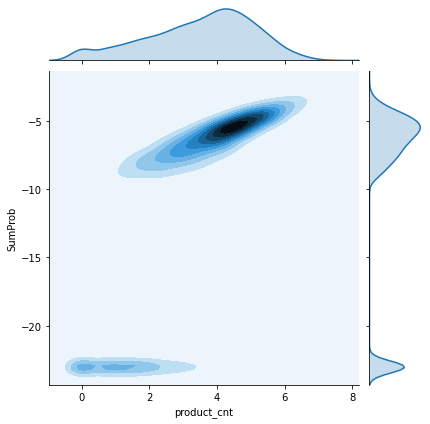

In [ ]:
product_cnt = get_productcnt(data)
product_sumprob = pd.DataFrame({'StockCode':product_id.StockCode, 'SumProb': np.sum(products_prob, axis=1)})
tmp = pd.merge(pd.merge(product_sumprob, product_cnt, on = 'StockCode'), productprob_df[['StockCode', 'Topic']], on='StockCode')
print (tmp.head())
snb.jointplot(x=np.log(tmp.product_cnt), y=np.log(tmp.SumProb+1e-10), kind='kde')

#### Grouping items from prob

- Check no-topic products

In [ ]:
print ('No-topic products: ')
notopic_product = np.where(np.sum(products_prob, axis=1)==0)[0]
print ('+ Number of products: ', len(notopic_product))
print (notopic_product[:10])
print (np.array(product_id.StockCode)[notopic_product][:10])

No-topic products: 
+ Number of products:  631
[ 19  74  87  88 109 119 159 290 295 302]
['10002' '84854' '37444A' '37444C' '21324' '22783' '22127' '84678' '22480'
 '20773']


- Check low-probability products



In [ ]:
print ('Low-prob products: ')
lowprob_product = np.where((np.sum(products_prob, axis=1)<=1e-3) & (np.sum(products_prob, axis=1)>1e-4))[0]
print ('+ Number of products: ', len(lowprob_product))
print (lowprob_product[:10])
print (np.array(product_id.StockCode)[lowprob_product][:10])
print ('+ Number of products in topics: ')
for t in range(num_topics):
    print ('    * Topic %d' %t, np.sum(np.argmax(products_prob[lowprob_product, :], axis=1)==t))

Low-prob products: 
+ Number of products:  879
[ 12 104 135 139 178 181 195 226 234 271]
['21777' '22719' '22242' '35004G' '85049D' '21061' '22803' '21587'
 '35591T' '22837']
+ Number of products in topics: 
    * Topic 0 53
    * Topic 1 42
    * Topic 2 68
    * Topic 3 81
    * Topic 4 29
    * Topic 5 30
    * Topic 6 47
    * Topic 7 53
    * Topic 8 20
    * Topic 9 18
    * Topic 10 33
    * Topic 11 31
    * Topic 12 191
    * Topic 13 66
    * Topic 14 73
    * Topic 15 44


- Check mid-probability products



In [ ]:
print ('Mid-prob products: ')
midprob_product = np.where((np.sum(products_prob, axis=1)<=1e-2) & (np.sum(products_prob, axis=1)>1e-3))[0]
print ('+ Number of products: ', len(midprob_product))
print (midprob_product[:10])
print (np.array(product_id.StockCode)[midprob_product][:10])
print ('+ Number of products in topics: ')
for t in range(num_topics):
    print ('    * Topic %d' %t, np.sum(np.argmax(products_prob[midprob_product, :], axis=1)==t))

Mid-prob products: 
+ Number of products:  1771
[ 3  5  6  7  8  9 17 18 21 25]
['22745' '22749' '22310' '84969' '22623' '22622' '21724' '21883' '21035'
 '22631']
+ Number of products in topics: 
    * Topic 0 113
    * Topic 1 87
    * Topic 2 147
    * Topic 3 128
    * Topic 4 105
    * Topic 5 111
    * Topic 6 90
    * Topic 7 95
    * Topic 8 75
    * Topic 9 49
    * Topic 10 106
    * Topic 11 130
    * Topic 12 205
    * Topic 13 94
    * Topic 14 142
    * Topic 15 94


- Check high-probability products



In [ ]:
print ('High-prob products: ')
higprob_product = np.where((np.sum(products_prob, axis=1)>=1e-2))[0] #(np.sum(products_prob, axis=1)<1e-2) &
print ('+ Number of products: ', len(higprob_product))
print (higprob_product[:10])
print (np.array(product_id.StockCode.unique())[higprob_product][:10])
print ('+ Number of products in topics: ')
for t in range(num_topics):
    print ('    * Topic %d' %t, np.sum(np.argmax(products_prob[higprob_product, :], axis=1)==t))

High-prob products: 
+ Number of products:  415
[ 0  1  2  4 10 11 13 14 15 16]
['22633' '22632' '84879' '22748' '21754' '21755' '48187' '22728' '22727'
 '22726']
+ Number of products in topics: 
    * Topic 0 13
    * Topic 1 27
    * Topic 2 21
    * Topic 3 23
    * Topic 4 25
    * Topic 5 28
    * Topic 6 31
    * Topic 7 30
    * Topic 8 30
    * Topic 9 33
    * Topic 10 25
    * Topic 11 25
    * Topic 12 7
    * Topic 13 42
    * Topic 14 18
    * Topic 15 37


##### Visualize groups


Milestones -20, -10 correspondingly are:  2.061153622438558e-09 4.5399929762484854e-05


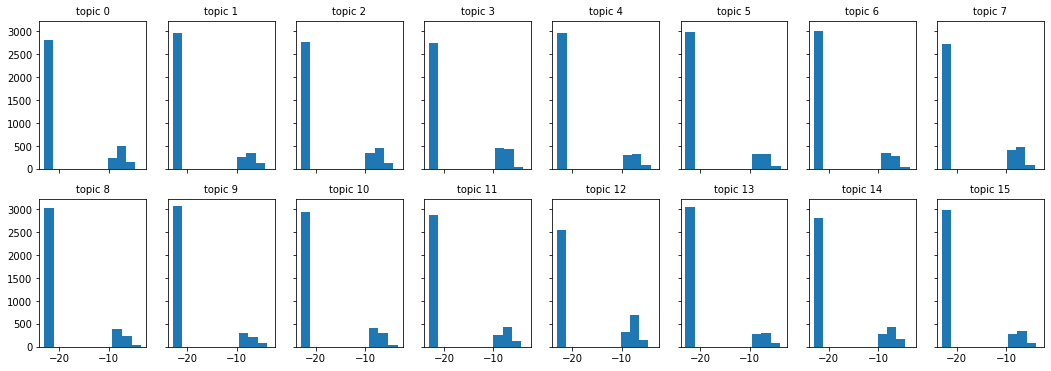

In [ ]:
visualize_topics_withprob(products_prob, np.array(range(len(product_id))))

High-prob products
Milestones -20, -10 correspondingly are:  2.061153622438558e-09 4.5399929762484854e-05


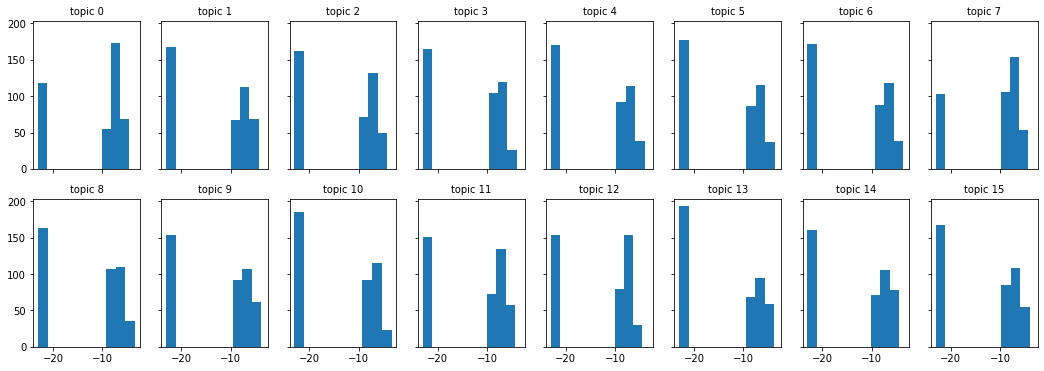

Middle-prob products
Milestones -20, -10 correspondingly are:  2.061153622438558e-09 4.5399929762484854e-05


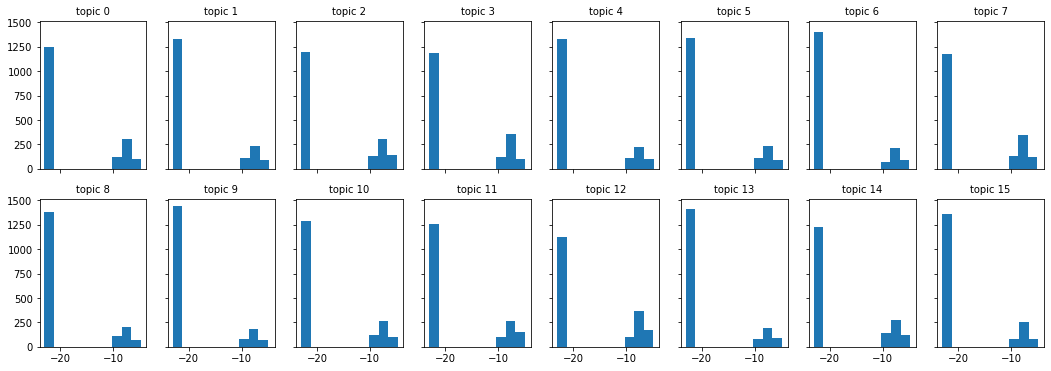

Low-prob products
Milestones -20, -10 correspondingly are:  2.061153622438558e-09 4.5399929762484854e-05


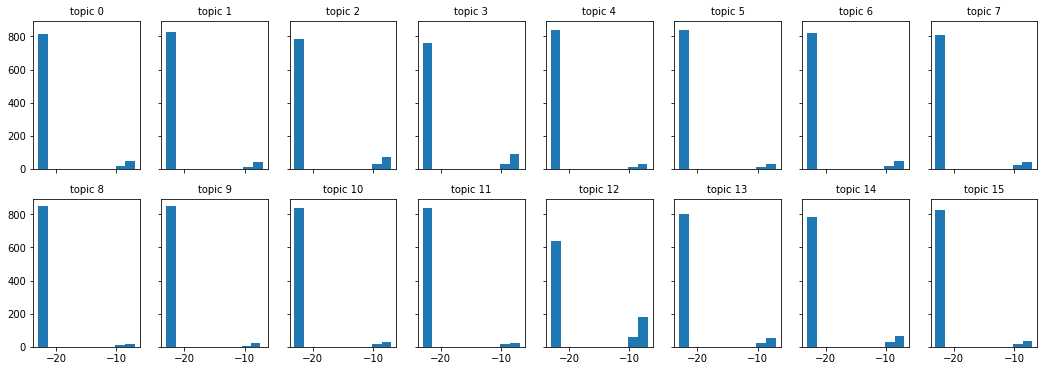

In [ ]:
print ('High-prob products')
visualize_topics_withprob(products_prob, higprob_product)
print ('Middle-prob products')
visualize_topics_withprob(products_prob, midprob_product)
print ('Low-prob products')
visualize_topics_withprob(products_prob, lowprob_product)

#### Compare user features on topics

In [ ]:
def compare_userontopics(data, user_feature, metric, ncol=8):
    tmp = pd.merge(data[['CustomerID', 'StockCode']], productprob_df[['StockCode', 'Topic']])
    tmp = pd.merge(tmp[['StockCode', 'Topic', 'CustomerID']], user_feature, on = 'CustomerID')
    tmp = tmp[['StockCode','Topic', 'CustomerID',metric]]
    print (tmp.head())

    plt.hist(np.log(user_feature[metric]))
    plt.show()

    nrow= int((int(num_topics-1)/ncol)+1)
    fig, axes = plt.subplots(nrow, ncol, figsize=(18, 6), sharex=True, sharey=True)
    for t, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        tmp2 = tmp[tmp.Topic==t]
        plt.hist(np.log(tmp2[metric])+1e-10)
    plt.show()

##### user_cnt

  StockCode  Topic CustomerID  user_cnt
0     22633      9      17850       153
1     22633      9      17850       153
2     22633      9      17850       153
3     22633      9      17850       153
4     22633      9      17850       153


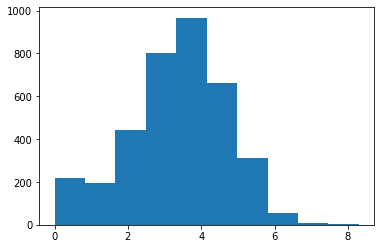

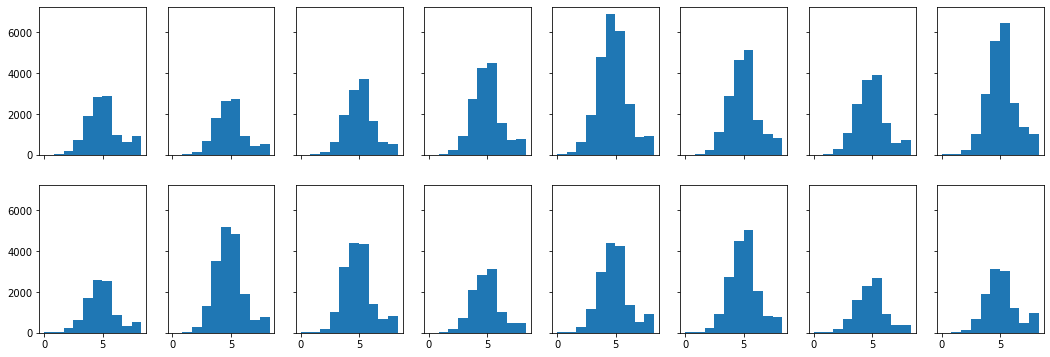

In [ ]:
usercnt = get_usercnt(data)
compare_userontopics(data, usercnt, 'user_cnt')

##### user_prodcnt

  StockCode  Topic CustomerID  avg_productcnt
0     22633      9      17850      330.849673
1     22633      9      17850      330.849673
2     22633      9      17850      330.849673
3     22633      9      17850      330.849673
4     22633      9      17850      330.849673


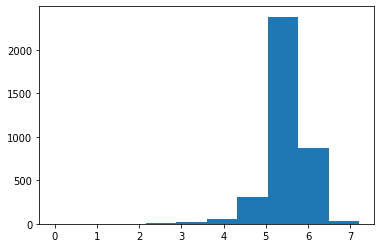

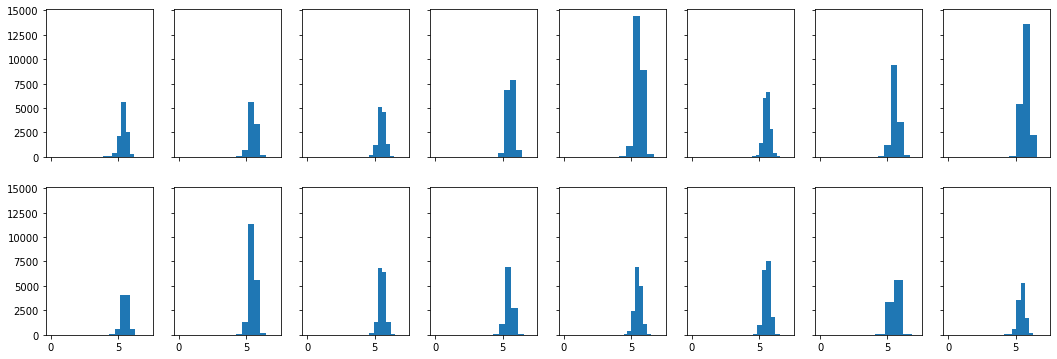

In [ ]:
user_productcnt = get_user_productcnt(data)
compare_userontopics(data, user_productcnt, 'avg_productcnt')

##### avg_invoicelen

  StockCode  Topic CustomerID  avg_invoicelen
0     22633      9      17850       10.928571
1     22633      9      17850       10.928571
2     22633      9      17850       10.928571
3     22633      9      17850       10.928571
4     22633      9      17850       10.928571


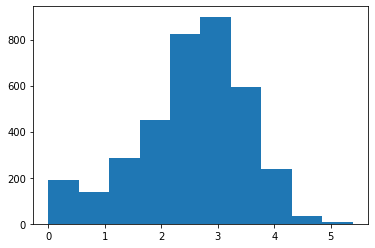

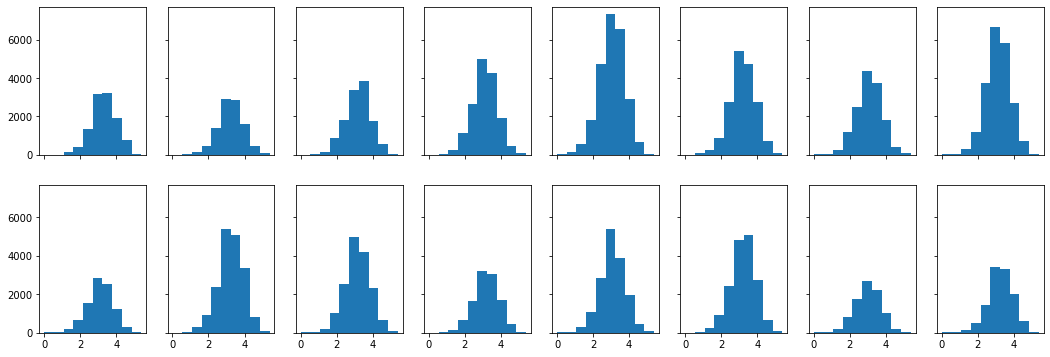

In [ ]:
user_invoicelen = get_user_invoicelen(data, metric='avg_invoicelen')
compare_userontopics(data, user_invoicelen, 'avg_invoicelen')

# **4. Recommend**

## ***Functions***

In [ ]:
def gettopidx_row(x, NTOP):
    res = np.argsort(x)[:NTOP+1] # recommending list includes NTOP+1: itself and NTOP others
    return res

def gettopidx_eachrow_matrix(arr, NTOP, metric='sim'):
    if metric == 'distance': #similarity or score
        return np.apply_along_axis(gettopidx_row, 1, arr, NTOP) #get top of arr after ascending  sort
    return np.apply_along_axis(gettopidx_row, 1, -arr, NTOP)      #get top of arr after descending sort

def keeppositive_idx(arr):
    x, y = np.where(arr >= 0) # filter itself and invalid values
    return x, y

def filteridx_matrix(rec_metric, NTOP, metric):
    '''
        - Sorted and limit NTOP idx of each row
        - Remove <= 0 idx of each row
        - Return idx of arr
    '''
    top_idx = gettopidx_eachrow_matrix(rec_metric, NTOP, metric)
    top_value = np.array([rec_metric[i, top_idx[i]] for i in range(len(top_idx))])
    x, y = keeppositive_idx(top_value)
    return x, top_idx[x, y]

def euclid_distance(x, y): #x, y: vector with shape (-1, 1)
    return np.sum((x-y)**2)

# def topic_distance(x, y, alpha=0.2):
    # return cosine(x, y)*alpha + euclid_distance(x,y)*(1-alpha)

In [ ]:
STOCK_CODEDES = (product_id.StockCode.unique(), stock2dec_mapping)

class IndexStocks:
    def __init__(self):
        stockcode_arr, stock2dec_mapping = STOCK_CODEDES
        self.stockcode_arr = stockcode_arr
        self.mapping = stock2dec_mapping

    def get_itemidx(self, items):
        find_items = lambda x: np.where(np.array(self.stockcode_arr)==x)[0][0]
        idx_items = np.apply_along_axis(find_items, 1, np.array(items).reshape(-1, 1))
        return idx_items

    def gettoprec_byid(self, idx_start_items, rec_matrix, metric, NTOP=5):
        items, rec_items = filteridx_matrix(rec_matrix, NTOP, metric=metric)
        return pd.DataFrame({'start_code':np.array(self.stockcode_arr)[idx_start_items[items]], \
                             'rec_code':np.array(self.stockcode_arr)[rec_items], \
                             'score':rec_matrix[items, rec_items]})

    def add_description(self, rec_df):
        rec_df['start_des'] = convert_mapping(self.mapping, rec_df['start_code'])
        rec_df['rec_des'] = convert_mapping(self.mapping, rec_df['rec_code'])
        return rec_df

## 4.1 Recommend by LDA features

### ***The Model***

In [ ]:
class LDA_REC(IndexStocks):
    def __init__(self, products_prob):
        IndexStocks.__init__(self)
        self.products_prob = products_prob
        self.full_simmatrix = None

    def __cal_recscore(self, x):
        cal_sim = lambda y: euclid_distance(x.reshape(-1, 1), y.reshape(-1, 1))
        np_sim = np.apply_along_axis(cal_sim, 1, self.products_prob)
        return np_sim.reshape(-1)

    def get_full_simmatrix(self):
        if self.full_simmatrix is None:
            self.full_simmatrix = self.cal_recscore(range(len(products_prob)))
        return self.full_simmatrix

    def cal_recscore(self, idx_start_items):
        return np.apply_along_axis(self.__cal_recscore, 1, self.products_prob[idx_start_items, :])

    def recommend(self, start_items, NTOP=5):
        idx_start_items = self.get_itemidx(start_items)
        sim_matrix = self.cal_recscore(idx_start_items)
        return self.gettoprec_byid(idx_start_items, sim_matrix, metric='distance', NTOP=NTOP)

### Recommend for multi-topic products


In [ ]:
lda_rec = LDA_REC(products_prob)

In [ ]:
start_items = ['23344', '85123A', '22989']
rec_df = lda_rec.recommend(start_items)
lda_rec.add_description(rec_df)

start_code  ...                             rec_des
0       23344  ...           JUMBO BAG 50'S CHRISTMAS 
1       23344  ...        JUMBO BAG VINTAGE CHRISTMAS 
2       23344  ...   PAPER CHAIN KIT VINTAGE CHRISTMAS
3       23344  ...           VINTAGE CHRISTMAS BUNTING
4       23344  ...              JUMBO BAG VINTAGE LEAF
5       23344  ...     PAPER CHAIN KIT 50'S CHRISTMAS 
6      85123A  ...  WHITE HANGING HEART T-LIGHT HOLDER
7      85123A  ...     NATURAL SLATE HEART CHALKBOARD 
8      85123A  ...               HEART OF WICKER LARGE
9      85123A  ...               HEART OF WICKER SMALL
10     85123A  ...         WOODEN FRAME ANTIQUE WHITE 
11     85123A  ...         SMALL WHITE HEART OF WICKER
12      22989  ...      SET 2 PANTRY DESIGN TEA TOWELS
13      22989  ...                   HERB MARKER BASIL
14      22989  ...              PANTRY SCRUBBING BRUSH
15      22989  ...                HERB MARKER ROSEMARY
16      22989  ...                   HERB MARKER THYME
17      22989  ...          COTTON APRON PANTRY DESIGN

[18 rows x 5 columns]

In [ ]:
productprob_df[productprob_df['StockCode'].isin(rec_df.start_code.unique())].sort_values(by='Topic')

StockCode  Topic   Topic_0  ...  Topic_13  Topic_14  Topic_15
3256     23344      2  0.000000  ...  0.000000  0.000145  0.000603
2741     22989      8  0.000163  ...  0.000462  0.000212  0.000191
35      85123A     13  0.006504  ...  0.015635  0.002809  0.009916

[3 rows x 18 columns]

In [ ]:
productprob_df[productprob_df['StockCode'].isin(rec_df.rec_code.unique())].sort_values(by='Topic')

StockCode  Topic   Topic_0  ...  Topic_13  Topic_14  Topic_15
3074     23202      1  0.000107  ...  0.000693  0.000000  0.000664
3319     23313      2  0.000000  ...  0.001580  0.000111  0.000885
3224     23343      2  0.000000  ...  0.000000  0.000000  0.000000
89       22086      2  0.000245  ...  0.000151  0.001774  0.002948
230      22910      2  0.000476  ...  0.000443  0.000000  0.000190
3256     23344      2  0.000000  ...  0.000000  0.000145  0.000603
2784     22980      8  0.000117  ...  0.000523  0.000000  0.000000
2745     22990      8  0.000000  ...  0.000000  0.000151  0.000000
2741     22989      8  0.000163  ...  0.000462  0.000212  0.000191
661      22917      8  0.000000  ...  0.000000  0.000000  0.000000
660      22916      8  0.000000  ...  0.000000  0.000000  0.000000
664      22920      8  0.000000  ...  0.000000  0.000000  0.000000
112      22470     13  0.001523  ...  0.011529  0.000278  0.000704
111      22469     13  0.003077  ...  0.008684  0.000433  0.000558
110      22457     13  0.006338  ...  0.010502  0.002043  0.003089
3215     23321     13  0.003082  ...  0.008853  0.000000  0.002817
46      82494L     13  0.001158  ...  0.006578  0.001129  0.003278
35      85123A     13  0.006504  ...  0.015635  0.002809  0.009916

[18 rows x 18 columns]

In [ ]:
start_items = ['23344', '85123A', '22989']
rec_df = lda_rec.recommend(start_items)
lda_rec.add_description(rec_df)

start_code  ...                             rec_des
0       23344  ...           JUMBO BAG 50'S CHRISTMAS 
1       23344  ...          SET OF 3 REGENCY CAKE TINS
2       23344  ...         BOX OF 6 MINI 50'S CRACKERS
3       23344  ...      BOX OF 6 MINI VINTAGE CRACKERS
4       23344  ...     60 CAKE CASES VINTAGE CHRISTMAS
5       23344  ...     PAPER CHAIN KIT 50'S CHRISTMAS 
6      85123A  ...  WHITE HANGING HEART T-LIGHT HOLDER
7      85123A  ...       ASSORTED COLOUR BIRD ORNAMENT
8      85123A  ...     ANTIQUE SILVER TEA GLASS ETCHED
9      85123A  ...  WOOD 2 DRAWER CABINET WHITE FINISH
10     85123A  ...     VICTORIAN GLASS HANGING T-LIGHT
11     85123A  ...         WOODEN FRAME ANTIQUE WHITE 
12      22989  ...      SET 2 PANTRY DESIGN TEA TOWELS
13      22989  ...  3 TRADITIONAl BISCUIT CUTTERS  SET
14      22989  ...              ABC TREASURE BOOK BOX 
15      22989  ...          COTTON APRON PANTRY DESIGN
16      22989  ...                  PANTRY ROLLING PIN
17      22989  ...     CHILDRENS CUTLERY CIRCUS PARADE

[18 rows x 5 columns]

In [ ]:
productprob_df[productprob_df['StockCode'].isin(rec_df.start_code.unique())].sort_values(by='Topic')

StockCode  Topic   Topic_0  ...  Topic_13  Topic_14  Topic_15
35      85123A      4  0.001302  ...  0.000997  0.003835  0.000627
3458     23344     10  0.000000  ...  0.000000  0.000000  0.005599
2870     22989     13  0.000000  ...  0.004382  0.000000  0.000000

[3 rows x 18 columns]

In [ ]:
productprob_df[productprob_df['StockCode'].isin(rec_df.rec_code.unique())].sort_values(by='Topic')

StockCode  Topic   Topic_0  ...  Topic_13  Topic_14  Topic_15
2        84879      4  0.000149  ...  0.002301  0.002526  0.000148
35      85123A      4  0.001302  ...  0.000997  0.003835  0.000627
43       82483      4  0.000000  ...  0.000000  0.001471  0.000000
46      82494L      4  0.000424  ...  0.000159  0.004251  0.000000
208      22178      4  0.001718  ...  0.000633  0.000160  0.000672
765      84946      4  0.002858  ...  0.000717  0.000691  0.000533
3458     23344     10  0.000000  ...  0.000000  0.000000  0.005599
3397     23245     10  0.000229  ...  0.002452  0.000913  0.000174
3522     23319     10  0.000000  ...  0.000755  0.000000  0.001385
231      22952     10  0.000676  ...  0.000000  0.000000  0.002555
89       22086     10  0.000699  ...  0.000240  0.000000  0.000739
3521     23318     10  0.000153  ...  0.000450  0.000000  0.005241
2870     22989     13  0.000000  ...  0.004382  0.000000  0.000000
2881     22990     13  0.000143  ...  0.004874  0.000000  0.000000
2938     22978     13  0.000000  ...  0.004153  0.000309  0.000000
2982     23176     13  0.000000  ...  0.004217  0.000000  0.000000
3157     23255     13  0.000000  ...  0.004226  0.000000  0.000000
1219     22965     13  0.000000  ...  0.004991  0.000000  0.000000

[18 rows x 18 columns]

### Reccommend for list of products from low/mid/high group


In [ ]:
tmp = productprob_df.iloc[np.array([notopic_product[0], lowprob_product[0], midprob_product[0], higprob_product[0]])]
print ('No-topic StockCode: ', product_id.iloc[notopic_product[0]].StockCode)
print ('Low-prob StockCode: ', product_id.iloc[lowprob_product[0]].StockCode)
print ('Mid-prob StockCode: ', product_id.iloc[midprob_product[0]].StockCode)
print ('High-prob StockCode: ', product_id.iloc[higprob_product[0]].StockCode)
tmp

No-topic StockCode:  10002
Low-prob StockCode:  21777
Mid-prob StockCode:  22745
High-prob StockCode:  22633


StockCode  Topic  Topic_0   Topic_1  ...  Topic_12  Topic_13  Topic_14  Topic_15
19     10002     16      0.0  0.000000  ...  0.000000       0.0       0.0  0.000000
12     21777      6      0.0  0.000000  ...  0.000000       0.0       0.0  0.000000
3      22745     10      0.0  0.002459  ...  0.000109       0.0       0.0  0.000000
0      22633     15      0.0  0.000313  ...  0.000000       0.0       0.0  0.016362

[4 rows x 18 columns]

In [ ]:
start_items = tmp.StockCode
rec_df = lda_rec.recommend(start_items)
lda_rec.add_description(rec_df)

start_code  ...                              rec_des
0       10002  ...          VINTAGE POST OFFICE CABINET
1       10002  ...         BLACK GEMSTONE NECKLACE 45CM
2       10002  ...   JARDIN ETCHED GLASS SMALL BELL JAR
3       10002  ...       VINTAGE KITCHEN PRINT PUDDINGS
4       10002  ...          WRAP GREEN RUSSIAN FOLKART 
5       10002  ...       BLACK DIAMOND CLUSTER EARRINGS
6       21777  ...          RECIPE BOX WITH METAL HEART
7       21777  ...  WOOLLY HAT SOCK GLOVE ADVENT STRING
8       21777  ...          APRON MODERN VINTAGE COTTON
9       21777  ...         REGENCY MIRROR WITH SHUTTERS
10      21777  ...             A4 WALL TIDY RED FLOWERS
11      21777  ...     PINK FELT HANGING HEART W FLOWER
12      22745  ...           POPPY'S PLAYHOUSE BEDROOM 
13      22745  ...            POPPY'S PLAYHOUSE KITCHEN
14      22745  ...        POPPY'S PLAYHOUSE LIVINGROOM 
15      22745  ...             TREASURE ISLAND BOOK BOX
16      22745  ...           POPPY'S PLAYHOUSE BATHROOM
17      22745  ...          GYMKHANNA TREASURE BOOK BOX
18      22633  ...               HAND WARMER UNION JACK
19      22633  ...           HAND WARMER RED LOVE HEART
20      22633  ...        HAND WARMER SCOTTY DOG DESIGN
21      22633  ...            HAND WARMER RED POLKA DOT
22      22633  ...               HAND WARMER OWL DESIGN
23      22633  ...        DOORMAT KEEP CALM AND COME IN

[24 rows x 5 columns]

In [ ]:
productprob_df[productprob_df['StockCode'].isin(rec_df.rec_code.unique())].sort_values(by='Topic')

StockCode  Topic   Topic_0  ...  Topic_13  Topic_14  Topic_15
2896     22828      6  0.000000  ...  0.000000  0.000000  0.000000
12       21777      6  0.000000  ...  0.000000  0.000000  0.000000
1104    35916C      6  0.000000  ...  0.000000  0.000000  0.000000
2727    71496B      6  0.000000  ...  0.000000  0.000000  0.000000
2341     21043      6  0.000000  ...  0.000000  0.000000  0.000000
2252     35832      6  0.000000  ...  0.000000  0.000000  0.000000
3        22745     10  0.000000  ...  0.000000  0.000000  0.000000
4        22748     10  0.000000  ...  0.000000  0.000000  0.000000
2842     23194     10  0.000175  ...  0.000186  0.000000  0.000544
2840     23177     10  0.000000  ...  0.000000  0.000120  0.000674
1083     22746     10  0.000000  ...  0.000000  0.000000  0.000000
1084     22747     10  0.000000  ...  0.000000  0.000000  0.000000
0        22633     15  0.000000  ...  0.000000  0.000000  0.016362
3407     23439     15  0.000140  ...  0.000252  0.000000  0.015083
3035     23284     15  0.000268  ...  0.002414  0.000540  0.018991
258      22865     15  0.000219  ...  0.000268  0.000229  0.019000
169      22866     15  0.000000  ...  0.000000  0.000121  0.011625
1        22632     15  0.000100  ...  0.000000  0.000000  0.011898
2136    16169P     16  0.000000  ...  0.000000  0.000000  0.000000
1158     90077     16  0.000000  ...  0.000000  0.000000  0.000000
2729     21278     16  0.000000  ...  0.000000  0.000000  0.000000
2730     85146     16  0.000000  ...  0.000000  0.000000  0.000000
2137    90196B     16  0.000000  ...  0.000000  0.000000  0.000000
1972     21769     16  0.000000  ...  0.000000  0.000000  0.000000

[24 rows x 18 columns]

In [ ]:
tmp = productprob_df.iloc[np.array([notopic_product[0], lowprob_product[0], midprob_product[0], higprob_product[0]])]
print ('Low-prob StockCode: ', product_id.iloc[notopic_product[0]].StockCode)
print ('Low-prob StockCode: ', product_id.iloc[lowprob_product[0]].StockCode)
print ('Mid-prob StockCode: ', product_id.iloc[midprob_product[0]].StockCode)
print ('High-prob StockCode: ', product_id.iloc[higprob_product[0]].StockCode)
tmp

Low-prob StockCode:  10002
Low-prob StockCode:  21777
Mid-prob StockCode:  22745
High-prob StockCode:  22633


StockCode  Topic   Topic_0   Topic_1  ...  Topic_12  Topic_13  Topic_14  Topic_15
19     10002     16  0.000000  0.000000  ...       0.0  0.000000       0.0  0.000000
12     21777      6  0.000000  0.000000  ...       0.0  0.000000       0.0  0.000000
3      22745      9  0.000155  0.000000  ...       0.0  0.000000       0.0  0.000205
0      22633      9  0.000000  0.000567  ...       0.0  0.000981       0.0  0.000710

[4 rows x 18 columns]

In [ ]:
start_items = tmp.StockCode
rec_df = lda_rec.recommend(start_items)
lda_rec.add_description(rec_df)

start_code  ...                              rec_des
0       10002  ...           LOVE POTION MASALA INCENSE
1       10002  ...       GLASS BEAD HOOP NECKLACE GREEN
2       10002  ...  RASPBERRY ANT COPPER FLOWER NECKLAC
3       10002  ...            RETRO BROWN BALL ASHTRAY 
4       10002  ...       WHITE VINTAGE CRYSTAL BRACELET
5       10002  ...      FOLKART ZINC STAR CHRISTMAS DEC
6       21777  ...          RECIPE BOX WITH METAL HEART
7       21777  ...             CHILDS GARDEN BRUSH BLUE
8       21777  ...      IVORY ENCHANTED FOREST PLACEMAT
9       21777  ...                                 <NA>
10      21777  ...         BLACK/BLUE POLKADOT UMBRELLA
11      21777  ...    BLUE CLIMBING HYDRANGA ART FLOWER
12      22745  ...           POPPY'S PLAYHOUSE BEDROOM 
13      22745  ...             VINTAGE SNAKES & LADDERS
14      22745  ...                     PICTURE DOMINOES
15      22745  ...            POPPY'S PLAYHOUSE KITCHEN
16      22745  ...   12 PENCILS TALL TUBE RED RETROSPOT
17      22745  ...              BAG 125g SWIRLY MARBLES
18      22633  ...               HAND WARMER UNION JACK
19      22633  ...           HAND WARMER RED LOVE HEART
20      22633  ...            HAND WARMER RED POLKA DOT
21      22633  ...              HAND WARMER BIRD DESIGN
22      22633  ...   PLAYING CARDS KEEP CALM & CARRY ON
23      22633  ...      SET 12 COLOUR PENCILS SPACEBOY 

[24 rows x 5 columns]

In [ ]:
productprob_df[productprob_df['StockCode'].isin(rec_df.rec_code.unique())].sort_values(by='Topic')

StockCode  Topic   Topic_0  ...  Topic_13  Topic_14  Topic_15
1440    85014a      6  0.000000  ...  0.000000  0.000000  0.000000
3695    84805B      6  0.000000  ...  0.000000  0.000000  0.000000
2492    85114b      6  0.000000  ...  0.000000  0.000000  0.000000
1429     22518      6  0.000000  ...  0.000000  0.000000  0.000000
3896    84971L      6  0.000000  ...  0.000000  0.000000  0.000000
12       21777      6  0.000000  ...  0.000000  0.000000  0.000000
169      22867      9  0.000000  ...  0.000000  0.000000  0.000000
1        22632      9  0.000000  ...  0.000000  0.000371  0.000219
3622     23439      9  0.000000  ...  0.000226  0.002565  0.000186
3        22745      9  0.000155  ...  0.000000  0.000000  0.000205
3703     23367      9  0.000379  ...  0.001127  0.000254  0.000923
0        22633      9  0.000000  ...  0.000981  0.000000  0.000710
1391     20983      9  0.000000  ...  0.000000  0.000000  0.000193
855      21703      9  0.000000  ...  0.000000  0.000000  0.000102
625      22549      9  0.000306  ...  0.000517  0.000000  0.000000
548      21912      9  0.000245  ...  0.000227  0.000000  0.000000
4        22748      9  0.000000  ...  0.000000  0.000000  0.000306
3701     23503     11  0.000106  ...  0.001437  0.002135  0.000415
1637     35958     16  0.000000  ...  0.000000  0.000000  0.000000
1961    17084J     16  0.000000  ...  0.000000  0.000000  0.000000
2952    90065A     16  0.000000  ...  0.000000  0.000000  0.000000
2955    90000A     16  0.000000  ...  0.000000  0.000000  0.000000
2956    90026C     16  0.000000  ...  0.000000  0.000000  0.000000
2337    84597B     16  0.000000  ...  0.000000  0.000000  0.000000

[24 rows x 18 columns]

## 4.2 item-item graph

### ***The Model***

Let $k_\alpha$ is purchased times of items $\alpha$.

Let call $ A $ is history as matrix. if user $j$ selected item $\alpha$:

$$a_{j\alpha} = 1$$

Calculating $ T $ is weights of products $\alpha$ in history of each user $j$:

$$ t_{j\alpha} = \dfrac{a_{j\alpha}k_{\alpha}^\gamma}{\sum_\beta a_{j\beta}k_\beta^\gamma} $$

Calculating $ H $ includes the weight when recommeding $\alpha$ for  $\beta$:

$$ h_{\alpha\beta} = \dfrac{1}{k_\alpha^{1-\lambda}k_\beta^\lambda}$$

Calculating $ W $ is item2item matrix when recommeding $\alpha$ for  $\beta$:

$$ w_{\alpha\beta} = h_{\alpha\beta}\sum_j{a_{j\alpha}a_{j\beta}t_{j\beta}}$$

means:

$$ W = H \circ (A^T \cdot (A \circ T))$$

Making Recommendation by $W$, larger score is better.

To recommend for all users:

$$ R = AW^T $$

In [ ]:
class ACF_REC(IndexStocks):
    def __init__(self, his_matrix, item_info, user_info=None, parameters={'gamma':0.5, 'lambda':0.7}):
        IndexStocks.__init__(self)
        self.A = his_matrix
        self.k_item = np.array(item_info[1]).reshape((-1))
        self.all_users = None
        if user_info != None:
            self.all_users = user_info[0]
        self.gamma, self.lam = parameters['gamma'], parameters['lambda']
        self.W, self.R = None, None

    def __get_itemuser_matrix(self):
        T = self.A * (self.k_item ** self.gamma)
        #normalize
        sumrow_T = np.sum(T, axis=1)
        T_trans = T.T
        T = (T_trans * (1/sumrow_T)).T
        return T

    def __get_weight_matrix(self):
        k_item_inv = 1/self.k_item
        H = np.dot(k_item_inv.reshape(-1, 1)**self.lam, k_item_inv.reshape(1,-1)**(1-self.lam))
        return H

    def get_itemitem_matrix(self):
        if self.W is None:
            T = self.__get_itemuser_matrix()
            H = self.__get_weight_matrix()
            self.W = H * np.dot(self.A.T, self.A*T)
            np.nan_to_num(self.W, copy=False)
        return self.W

    def __recommend_itemidx(self, start_idx):
        tmp_W = self.get_itemitem_matrix()[:, start_idx].T
        return tmp_W

    def recommend(self, start_items, NTOP=5):
        idx_start_items = self.get_itemidx(start_items)
        score_metric = self.__recommend_itemidx(idx_start_items)
        return self.gettoprec_byid(idx_start_items, score_metric, metric='sim', NTOP=NTOP)

    def __get_useridx(self, id_users):
        find_users = lambda x: np.where(np.array(self.all_users)==x)[0][0]
        idx_users = np.apply_along_axis(find_users, 1, np.array(id_users).reshape(-1, 1))
        return idx_users

    def get_useritem_matrix(self):
        W = self.get_itemitem_matrix()
        return np.dot(self.A, W.T)

    def recommend_byusers(self, user_id, NTOP=5):
        user_idx = self.__get_useridx(user_id)
        user_his_idx = np.where(self.A[user_idx]==1)[1]
        score_metric = self.__recommend_itemidx(user_his_idx)
        rec_df = self.gettoprec_byid(user_his_idx, score_metric, metric='sim')
        return rec_df.groupby(['rec_code'])['score'].sum().reset_index(name='score').sort_values(by='score', ascending=0).head(NTOP)

In [ ]:
def parse_input(data, product_id):
    all_cus = np.array(data.CustomerID.dropna().unique())
    all_products = np.array(product_id.StockCode.unique())

    his_df = data[['CustomerID', 'StockCode']].dropna()
    user_cnt = get_usercnt(his_df).drop_duplicates()
    prod_cnt = get_productcnt(his_df).drop_duplicates()
    product_id=product_id.merge(prod_cnt, on='StockCode', how='left')
    product_id['product_cnt'] = product_id['product_cnt'].fillna(0)

    his_df = his_df.drop_duplicates()
    cus2id_mapping = create_mapping(his_df['CustomerID'].unique(), range(len(all_cus)))
    prod2id_mapping =create_mapping(product_id['StockCode'], range(len(product_id)))

    his_df['cus_idx'] = convert_mapping(cus2id_mapping, his_df['CustomerID'])
    his_df['prod_idx'] = convert_mapping(prod2id_mapping, his_df['StockCode'])

    Sizes = {'his':len(his_df), 'cus':len(all_cus), 'prod':len(all_products)}
    data_packages = Sizes, his_df, user_cnt, product_id
    return data_packages

def get_hismatrix(data_packages):
    Sizes, his_df, user_cnt, prod_cnt = data_packages
    his_matrix = np.zeros((Sizes['cus'], Sizes['prod']))
    his_matrix[np.array(his_df['cus_idx']), np.array(his_df['prod_idx'])]=1
    return his_matrix

In [ ]:
data_packages = parse_input(data, product_id)
his_matrix = get_hismatrix(data_packages)
_, his_df, user_cnt, prod_cnt = data_packages

item_info = (prod_cnt.StockCode, prod_cnt.product_cnt+1)
user_info = (user_cnt.CustomerID, user_cnt.user_cnt)

###  Recommend from items

#### Recommend for multi-topic products

In [ ]:
start_items = ['23344', '85123A', '22989']
rec_df = acf_model.recommend(start_items)
acf_model.add_description(rec_df)

start_code  ...                             rec_des
0       23344  ...           JUMBO BAG 50'S CHRISTMAS 
1       23344  ...        JUMBO BAG VINTAGE CHRISTMAS 
2       23344  ...                   FOLDING SHOE TIDY
3       23344  ...        VINTAGE DOILY JUMBO BAG RED 
4       23344  ...       WALL ART WORK REST AND PLAY  
5       23344  ...                  JUMBO BAG ALPHABET
6      85123A  ...  WHITE HANGING HEART T-LIGHT HOLDER
7      85123A  ...     CANDLEHOLDER PINK HANGING HEART
8      85123A  ...    RED HANGING HEART T-LIGHT HOLDER
9      85123A  ...         WHITE BAMBOO RIBS LAMPSHADE
10     85123A  ...            M/COLOUR POM-POM CURTAIN
11     85123A  ...   JET BLACK LAS VEGAS NECKLACE 45CM
12      22989  ...      SET 2 PANTRY DESIGN TEA TOWELS
13      22989  ...          COTTON APRON PANTRY DESIGN
14      22989  ...                  PANTRY ROLLING PIN
15      22989  ...          BLUE SQUARE COMPACT MIRROR
16      22989  ...    PACK OF 20 NAPKINS PANTRY DESIGN
17      22989  ...     SET/4 GARDEN ROSE DINNER CANDLE

[18 rows x 5 columns]

In [ ]:
productprob_df[productprob_df['StockCode'].isin(rec_df.rec_code.unique())].sort_values(by='Topic')

StockCode  Topic   Topic_0  ...  Topic_13  Topic_14  Topic_15
52       21733      0  0.006346  ...  0.003229  0.000179  0.005299
2966     23201      1  0.000296  ...  0.001144  0.000607  0.000559
3256     23344      2  0.000000  ...  0.000000  0.000145  0.000603
3224     23343      2  0.000000  ...  0.000000  0.000000  0.000000
2033    90211B      3  0.000000  ...  0.000000  0.000000  0.000000
3621     23582      6  0.000329  ...  0.000378  0.000160  0.001938
2800     22978      8  0.000227  ...  0.000000  0.000000  0.000000
2745     22990      8  0.000000  ...  0.000000  0.000151  0.000000
1433     22907      8  0.000000  ...  0.001265  0.000741  0.000000
2741     22989      8  0.000163  ...  0.000462  0.000212  0.000191
35      85123A     13  0.006504  ...  0.015635  0.002809  0.009916
2956    84875D     14  0.000000  ...  0.000000  0.000200  0.000000
1182     22804     15  0.000997  ...  0.002250  0.000000  0.002573
3548     23532     15  0.000000  ...  0.000000  0.000000  0.000898
3618     45013     16  0.000000  ...  0.000000  0.000000  0.000000
2754     44265     16  0.000000  ...  0.000000  0.000000  0.000000
2704    72798C     16  0.000000  ...  0.000000  0.000000  0.000000
2048     40003     16  0.000000  ...  0.000000  0.000000  0.000000

[18 rows x 18 columns]

#### Reccommend for list of products from low/mid/high group


In [ ]:
acf_model = ACF_REC(his_matrix, item_info, user_info, parameters={'gamma':0.5, 'lambda':0.7})

In [ ]:
tmp = productprob_df.iloc[np.array([notopic_product[0], lowprob_product[0], midprob_product[0], higprob_product[0]])]
print ('No-topic StockCode: ', product_id.iloc[notopic_product[0]].StockCode)
print ('Low-prob StockCode: ', product_id.iloc[lowprob_product[0]].StockCode)
print ('Mid-prob StockCode: ', product_id.iloc[midprob_product[0]].StockCode)
print ('High-prob StockCode: ', product_id.iloc[higprob_product[0]].StockCode)
tmp

No-topic StockCode:  10002
Low-prob StockCode:  21777
Mid-prob StockCode:  22745
High-prob StockCode:  22633


StockCode  Topic  Topic_0   Topic_1  ...  Topic_12  Topic_13  Topic_14  Topic_15
19     10002     16      0.0  0.000000  ...  0.000000       0.0       0.0  0.000000
12     21777      6      0.0  0.000000  ...  0.000000       0.0       0.0  0.000000
3      22745     10      0.0  0.002459  ...  0.000109       0.0       0.0  0.000000
0      22633     15      0.0  0.000313  ...  0.000000       0.0       0.0  0.016362

[4 rows x 18 columns]

In [ ]:
start_items = tmp.StockCode
rec_df = acf_model.recommend(start_items)
acf_model.add_description(rec_df)

start_code  ...                              rec_des
0       10002  ...          INFLATABLE POLITICAL GLOBE 
1       10002  ...       BLUE WIRE SPIRAL CANDLE HOLDER
2       10002  ...             EIGHT PIECE DINOSAUR SET
3       10002  ...                HEARTS WRAPPING TAPE 
4       10002  ...      PINK HANGING GINGHAM EASTER HEN
5       10002  ...      BLUE HANGING GINGHAM EASTER HEN
6       21777  ...          RECIPE BOX WITH METAL HEART
7       21777  ...       WOVEN BUBBLE GUM CUSHION COVER
8       21777  ...         PINK B'FLY C/COVER W BOBBLES
9       21777  ...       FRENCH CHATEAU SMALL FRUITBOWL
10      21777  ...         PSYCHEDELIC WALL THERMOMETER
11      21777  ...        SET OF 6 VINTAGE NOTELETS KIT
12      22745  ...           POPPY'S PLAYHOUSE BEDROOM 
13      22745  ...           METAL TUBE CHIME ON BAMBOO
14      22745  ...            POPPY'S PLAYHOUSE KITCHEN
15      22745  ...        POPPY'S PLAYHOUSE LIVINGROOM 
16      22745  ...     TABLE LAMP WHITE SHADE WOOD BASE
17      22745  ...           POPPY'S PLAYHOUSE BATHROOM
18      22633  ...               HAND WARMER UNION JACK
19      22633  ...  BLACK GLASS BRACELET W HEART CHARMS
20      22633  ...            HAND WARMER RED POLKA DOT
21      22633  ...           HAND WARMER RED LOVE HEART
22      22633  ...        HAND WARMER SCOTTY DOG DESIGN
23      22633  ...    BLACK FINE BEAD NECKLACE W TASSEL

[24 rows x 5 columns]

In [ ]:
productprob_df[productprob_df['StockCode'].isin(rec_df.rec_code.unique())].sort_values(by='Topic')

StockCode  Topic  Topic_0  ...  Topic_13  Topic_14  Topic_15
941      84360      5  0.00000  ...  0.000000  0.000000  0.000000
12       21777      6  0.00000  ...  0.000000  0.000000  0.000000
1865    90179C      6  0.00000  ...  0.000000  0.000000  0.000000
1886    84925F      8  0.00000  ...  0.000000  0.000000  0.000000
1662     84881      9  0.00000  ...  0.000000  0.000000  0.000000
3        22745     10  0.00000  ...  0.000000  0.000000  0.000000
4        22748     10  0.00000  ...  0.000000  0.000000  0.000000
1083     22746     10  0.00000  ...  0.000000  0.000000  0.000000
1084     22747     10  0.00000  ...  0.000000  0.000000  0.000000
2574    90197B     12  0.00000  ...  0.000000  0.000000  0.000000
1813    46776A     14  0.00000  ...  0.000000  0.002014  0.000000
0        22633     15  0.00000  ...  0.000000  0.000000  0.016362
3407     23439     15  0.00014  ...  0.000252  0.000000  0.015083
169      22866     15  0.00000  ...  0.000000  0.000121  0.011625
1        22632     15  0.00010  ...  0.000000  0.000000  0.011898
1714     21826     16  0.00000  ...  0.000000  0.000000  0.000000
713      85016     16  0.00000  ...  0.000000  0.000000  0.000000
19       10002     16  0.00000  ...  0.000000  0.000000  0.000000
2072     75131     16  0.00000  ...  0.000000  0.000000  0.000000
2353     84906     16  0.00000  ...  0.000000  0.000000  0.000000
2598    84745A     16  0.00000  ...  0.000000  0.000000  0.000000
2599    84745B     16  0.00000  ...  0.000000  0.000000  0.000000
2933    85028S     16  0.00000  ...  0.000000  0.000000  0.000000
1383    10123C     16  0.00000  ...  0.000000  0.000000  0.000000

[24 rows x 18 columns]

In [ ]:
# start_items = ['23344', '85123A', '22989']


### Recommmend from history of current user

In [ ]:
cus_id = np.array(user_cnt.CustomerID)[1]
print ('History of Customer %s' % cus_id)
data[data.CustomerID==cus_id].drop_duplicates(subset=['StockCode'])

History of Customer 14911


InvoiceNo StockCode  ... CustomerID  Country
1404      536540     22968  ...      14911     EIRE
1405      536540    85071A  ...      14911     EIRE
1406      536540    85071C  ...      14911     EIRE
1407      536540     22355  ...      14911     EIRE
1408      536540     21579  ...      14911     EIRE
...          ...       ...  ...        ...      ...
539129    581433     84821  ...      14911     EIRE
539131    581433     22914  ...      14911     EIRE
539132    581433     20718  ...      14911     EIRE
539134    581433     21111  ...      14911     EIRE
539155    581433    79302M  ...      14911     EIRE

[1423 rows x 7 columns]

In [ ]:
rec_df = acf_model.recommend_byusers(cus_id, NTOP=5)
rec_df['rec_description'] = convert_mapping(stock2dec_mapping, rec_df.rec_code)
rec_df

rec_code     score                    rec_description
220    23175  0.052449             REGENCY MILK JUG PINK 
125    22722  0.047096  SET OF 6 SPICE TINS PANTRY DESIGN
219    23174  0.046929           REGENCY SUGAR BOWL GREEN
93     22423  0.041544           REGENCY CAKESTAND 3 TIER
163    22960  0.041471           JAM MAKING SET WITH JARS

## 4.4 Hybrid

### ***Function***

In [ ]:
rec_obj = IndexStocks()
def scale(x, inv=False):
    vmin, vmax = np.min(x), np.max(x)
    res = (x-vmin)/(vmax-vmin)
    if inv:
        return 1-res
    return res

### 4.3.1 Simple Hybrid

Recommending $\alpha$ given $\beta$:

 $$ r_\alpha(\beta) = \sum_i w_i*s_i(\alpha, \beta)$$

 where $ s_i$ is score of one of previous models.

In [ ]:
rec_bytopic_model = LDA_REC(products_prob)
rec_bygraph_model = ACF_REC(his_matrix, item_info, user_info, parameters={'gamma':0.5, 'lambda':0.7})

def hybrid_results(start_items, cus_id, w = [0.4, 0.5, 0.1]):
    rec_bytopic = rec_bytopic_model.recommend(start_items, NTOP=100)
    rec_bygraph_foritem = rec_bygraph_model.recommend(start_items, NTOP=100)
    rec_bygraph_foruser = pd.DataFrame({'rec_code':[], 'score':[]})
    if (cus_id != None) and (cus_id != ''):
        rec_bygraph_foruser = rec_bygraph_model.recommend_byusers(cus_id, NTOP=100)

    rec_bytopic = rec_bytopic.rename(columns={'score':'score_bytopic'}).drop(['start_code'], axis=1)
    rec_bygraph_foritem = rec_bygraph_foritem.rename(columns={'score':'score_bygraph_item'}).drop(['start_code'], axis=1)
    rec_bygraph_foruser.rename(columns={'score':'score_bygraph_user'}, inplace = True)

    rec = pd.merge(pd.merge(rec_bytopic, rec_bygraph_foritem, on='rec_code', how='outer'), rec_bygraph_foruser, on='rec_code', how='outer')
    rec['score_bytopic']= scale(rec['score_bytopic'], inv=True)
    for c in ['score_bygraph_item', 'score_bygraph_user']:
        rec[c]= scale(rec[c])
    rec.fillna(0, inplace=True)

    cal_score = lambda r: r.score_bytopic * w[0] + r.score_bygraph_item *w[1] + r.score_bygraph_user * w[2]
    rec['score'] = rec.apply(lambda r: cal_score(r), axis=1)
    rec = rec.sort_values(by='score', ascending=0).reset_index(drop=True).head(6)
    rec['start_code']=np.array([start_items]*len(rec))
    return rec[['start_code', 'rec_code','score_bytopic', 'score_bygraph_item', 'score_bygraph_user', 'score']]

In [ ]:
start_items = ['23344']
cus_id = np.array(user_cnt.CustomerID)[1]
rec = hybrid_results(start_items, cus_id, w = [0.4, 0.5, 0.1])
rec_obj.add_description(rec)

start_code  ...                            rec_des
0      23344  ...          JUMBO BAG 50'S CHRISTMAS 
1      23344  ...       JUMBO BAG VINTAGE CHRISTMAS 
2      23344  ...  PAPER CHAIN KIT VINTAGE CHRISTMAS
3      23344  ...    PAPER CHAIN KIT 50'S CHRISTMAS 
4      23344  ...             JUMBO BAG VINTAGE LEAF
5      23344  ...          VINTAGE CHRISTMAS BUNTING

[6 rows x 8 columns]

### 4.3.2 Training weights

- **Simple version**

Separate purchases to form inputs and outputs

- The input is set of each item in the invoice, and the output is the rest of items in the invoice. Thus, each invoice with n items bring the input n lines.
- Model:
    - From input lines, determine $\beta$
    - From score of previous models, determine $s_i(., \beta)$
    - Compute $t(\alpha, \beta)=\sum_i w_i*s_i(\alpha,\beta)$ where $w$ is weights of score
    - Use sigmoid to transform $t$ to range $[0, 1]$: $f = sigmoid(t)$
- Loss function:
    - If $f(\alpha, \beta) > 0.5$, recommend $\alpha$
    - Compute mean square errror (MAE) or mean absolute error (MAE) from $f$ to label (0/1).

- More parameters version
    - Compute $t(\alpha, \beta)=\sum_i w_i(\alpha, \beta)*s_i(\alpha,\beta)$ where $w$ is weights of score and $\beta$



#### *4.3.2.1 Preparation*


##### ***Prepare matrix of recommending score***

- *Topic score*

In [ ]:
rec_bytopic_model = LDA_REC(products_prob)
topicrec_matrix = rec_bytopic_model.get_full_simmatrix()
itemtopic_matrix = np.apply_along_axis(scale, 1, topicrec_matrix, inv=True)
usertopic_matrix = np.dot(his_matrix,itemtopic_matrix.T)
usertopic_matrix = np.apply_along_axis(scale, 1, usertopic_matrix)
print (np.sum(np.isnan(itemtopic_matrix)))
print (np.sum(np.isnan(usertopic_matrix)))
del topicrec_matrix

0
0


- *Graph score*

In [ ]:
rec_bygraph_model = ACF_REC(his_matrix, item_info, user_info, parameters={'gamma':0.5, 'lambda':0.7})
graphrec_matrix = rec_bygraph_model.get_itemitem_matrix()
usergraph_matrix = rec_bygraph_model.get_useritem_matrix()
itemgraph_matrix = np.nan_to_num(np.apply_along_axis(scale, 1, graphrec_matrix))
usergraph_matrix = np.nan_to_num(np.apply_along_axis(scale, 1, usergraph_matrix))
print (np.sum(np.isnan(graphrec_matrix)))
print (np.sum(np.isnan(itemgraph_matrix)))
print (np.sum(np.isnan(usergraph_matrix)))
del graphrec_matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


0
0
0


In [ ]:
product_mats = {'item_graph': itemgraph_matrix.T, 'item_topic': itemtopic_matrix.T} #rec in second dimension
user_mats = {'user_graph': usergraph_matrix, 'user_topic': usertopic_matrix}

##### ***Prepare data***

- *Matrices of invoice*

In [ ]:
def index_data(data, product_id, user_cnt):
    tmp = data[(data.Quantity>0) & (data.UnitPrice > 0)].dropna().drop_duplicates()
    len_invoice = tmp.groupby(['InvoiceNo'])['StockCode'].apply(lambda r: len(list(r))).reset_index(name='len')
    tmp = pd.merge(tmp, len_invoice, on ='InvoiceNo', how = 'left')
    print (len(tmp), len (tmp[tmp['len']>=30]))
    purchase_df = tmp[tmp['len']>=30]
    del tmp
    del purchase_df['len']

    invoice_id = pd.DataFrame({'InvoiceNo':purchase_df.InvoiceNo.unique()})
    invoice_id = pd.merge(invoice_id, purchase_df[['InvoiceNo', 'CustomerID']].drop_duplicates(), on='InvoiceNo', how = 'left')
    invoice2idx_mapping = create_mapping(invoice_id.InvoiceNo, range(len(invoice_id)))
    prod2idx_mapping = create_mapping(product_id.StockCode, range(len(product_id)))
    cus2idx_mapping = create_mapping(user_cnt.CustomerID, range(len(user_cnt)))

    purchase_df['pur_idx']=range(len(purchase_df))
    purchase_df['invoice_idx'] = convert_mapping(invoice2idx_mapping, purchase_df['InvoiceNo'])
    purchase_df['prod_idx'] = convert_mapping(prod2idx_mapping, purchase_df['StockCode'])
    purchase_df['cus_idx'] = convert_mapping(cus2idx_mapping, purchase_df['CustomerID'])

    return invoice_id, purchase_df[['pur_idx', 'invoice_idx', 'prod_idx', 'cus_idx', 'Quantity', 'UnitPrice']]

def parse_tomatrices(invoice_id, product_id, user_cnt, purchase_df):
    invoice_prod = np.zeros((len(invoice_id), len(product_id)))
    invoice_prod[purchase_df['invoice_idx'], purchase_df['prod_idx']] = 1

    #output
    tmp = pd.merge(purchase_df[['pur_idx', 'invoice_idx']], purchase_df[['invoice_idx', 'prod_idx']], on = 'invoice_idx', how='outer')
    pur_out = np.zeros((len(purchase_df), len(product_id)))
    pur_out[tmp.pur_idx, tmp.prod_idx]=1

    #input
    pur_user = np.zeros((len(purchase_df), len(user_cnt)))
    pur_item = np.zeros((len(purchase_df), len(product_id)))
    pur_up = np.zeros((len(purchase_df), len(product_id)))
    pur_quan = np.zeros((len(purchase_df), len(product_id)))

    pur_user[purchase_df['pur_idx'], purchase_df['cus_idx']] = 1
    pur_item[purchase_df['pur_idx'], purchase_df['prod_idx']] = 1
    # pur_up[purchase_df['pur_idx'], purchase_df['prod_idx']] = purchase_df['UnitPrice']
    # pur_quan[purchase_df['pur_idx'], purchase_df['prod_idx']] = purchase_df['Quantity']
    # purchases = {'pur_out': pur_out, 'pur_user':pur_user, 'pur_item':pur_item, 'pur_up': pur_up, 'pur_quan':pur_quan}

    purchases = {'pur_out': pur_out, 'pur_user':pur_user, 'pur_item':pur_item}
    return invoice_prod, purchases

In [ ]:
n_subset = 1000
# del invoice_subuset
# del data_subset
invoice_subuset = data.InvoiceNo.unique()[:n_subset]
data_subset = data[data.InvoiceNo.isin(invoice_subuset)]
print (len(data_subset), len(data))

20399 313136


In [ ]:
# del invoice_id
# del purchase_df
# del invoice_prod
# del purchases
invoice_id, purchase_df = index_data(data_subset, product_id, user_cnt)
invoice_prod, purchases = parse_tomatrices(invoice_id, product_id, user_cnt, purchase_df)
print (invoice_prod.shape)
for k, v in purchases.items():
    print (k, v.shape)

14109 7198
(151, 3696)
pur_out (7198, 3696)
pur_user (7198, 3655)
pur_item (7198, 3696)


In [ ]:
sz=purchases['pur_out'].shape
print ('Rate of selected products in total products: ', np.sum(purchases['pur_out']==1)*1.0/(sz[0]*sz[1]))

Rate of selected products in total products:  0.01449341387518659


- *Tensor data*

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
x_ig = torch.from_numpy(np.dot(purchases['pur_item'],product_mats['item_graph'])).float().to(device)
x_ug = torch.from_numpy(np.dot(purchases['pur_user'],user_mats['user_graph'])).float().to(device)
x_it = torch.from_numpy(np.dot(purchases['pur_item'],product_mats['item_topic'])).float().to(device)
x_ut = torch.from_numpy(np.dot(purchases['pur_user'],user_mats['user_topic'])).float().to(device)
print (x_ig.shape, x_ug.shape, x_it.shape, x_ut.shape)

torch.Size([7198, 3696]) torch.Size([7198, 3696]) torch.Size([7198, 3696]) torch.Size([7198, 3696])


In [ ]:
y = torch.from_numpy(purchases['pur_out']).float().to(device)
print (y.shape)

torch.Size([7198, 3696])


##### ***Training functions***

In [ ]:
cal_mae = lambda y: np.mean(abs(y-purchases['pur_out']), axis=1).mean()
cal_mae_0 = lambda y: np.mean(y[idx0[0], idx0[1]])
cal_mae_1 = lambda y: np.mean(abs(y[idx1[0], idx1[1]]-1))

def MSE(output, target, weights=[0.05, 0.95]):
    output = torch.clamp(output,min=1e-8,max=1-1e-8)
    if weights is not None:
        assert len(weights) == 2
        loss = weights[1] * (target * (1-output)**2) + \
               weights[0] * ((1-target) * output**2)
    else:
        loss = (target * (1-output)**2) + ((1-target) * output**2)
    return torch.mean(loss)

def WBE(output, target, weights=[0.05, 0.95]):
    output = torch.clamp(output,min=1e-8,max=1-1e-8)
    if weights is not None:
        assert len(weights) == 2
        loss = weights[1] * (target * (1-output)) + \
               weights[0] * ((1-target) * output)
    else:
        loss = (target * (1-output)) + ((1-target) * output)
    return torch.mean(loss)

In [ ]:
idx0 = np.where(purchases['pur_out']==0)
idx1 = np.where(purchases['pur_out']==1)

def train(model, epochs=20, weights=[0.05, 0.95]):
    loss_list = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(x_ug, x_ig, x_ut, x_it).float()

        # Compute Loss
        # loss = criterion(y_pred, y)
        # loss = WBE(y_pred, y, weights)
        loss = MSE(y_pred, y, weights)
        # Backward pass
        if (epoch==0 or epoch%5==4):
            y_pred_np = y_pred.cpu().detach().numpy()
            mae, mae_0, mae_1 = cal_mae(y_pred_np), cal_mae_0(y_pred_np), cal_mae_1(y_pred_np)
            print ('Epoch %d: MSE=%f, MAE=%f, MAE_0=%f, MAE_1=%f' % (epoch, loss, mae, mae_0, mae_1))
            # print ('Epoch %d: WBE=%f, MAE=%f, MAE_0=%f, MAE_1=%f' % (epoch, loss, mae, mae_0, mae_1))
            # print ('Epoch %d: WBCE=%f, MAE=%f, MAE_0=%f, MAE_1=%f' % (epoch, loss, mae, mae_0, mae_1))
            # print ('Epoch %d: BCE=%f, MAE=%f, MAE_0=%f, MAE_1=%f' % (epoch, loss, mae, mae_0, mae_1))
        loss_list.append(loss)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    return y_pred_np, loss_list

##### ***The Model***

In [ ]:
from torch.autograd import Variable
from torch.nn import functional as Func

class LogisticRegression_Simple(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression_Simple, self).__init__()
        self.scalar_itemgraph = torch.nn.Parameter(torch.randn((1,1), requires_grad=True))
        self.scalar_usergraph = torch.nn.Parameter(torch.randn((1,1), requires_grad=True))
        self.scalar_itemtopic = torch.nn.Parameter(torch.randn((1,1), requires_grad=True))
        self.scalar_usertopic = torch.nn.Parameter(torch.randn((1,1), requires_grad=True))

     def forward(self, x_ug, x_ig, x_ut, x_it):
        tmp_ug = x_ug * self.scalar_usergraph.expand_as(x_ug) #self.linear_usergraph(x_ug)
        tmp_ig = x_ig * self.scalar_itemgraph.expand_as(x_ig) #self.linear_itemgraph(x_ig)
        tmp_ut = x_ut * self.scalar_usertopic.expand_as(x_ut) #self.linear_usergraph(x_ut)
        tmp_it = x_it * self.scalar_itemtopic.expand_as(x_it) #self.linear_itemgraph(x_it)
        pur_pred = torch.sigmoid(tmp_ug + tmp_ig + tmp_ut + tmp_it)
        return pur_pred

class LogisticRegression(torch.nn.Module):
     def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear_itemgraph = torch.nn.Linear(input_size, output_size)
        self.linear_usergraph = torch.nn.Linear(input_size, output_size)
        self.linear_itemtopic = torch.nn.Linear(input_size, output_size)
        self.linear_usertopic = torch.nn.Linear(input_size, output_size)

     def forward(self, x_ug, x_ig, x_ut, x_it):
        tmp_ug = self.linear_usergraph(x_ug)
        tmp_ig = self.linear_itemgraph(x_ig)
        tmp_ut = self.linear_usergraph(x_ut)
        tmp_it = self.linear_itemgraph(x_it)
        pur_pred = torch.sigmoid(tmp_ug + tmp_ig + tmp_ut + tmp_it)
        return pur_pred

##### ***Visualize rec***

In [ ]:
def get_rec_withweight(product_code, cus_id, product_mats, user_mats, product_id, user_cnt, weights, version='full'):
    w_ig_idx, w_it_idx, w_ug_idx, w_ut_idx = None, None, None, None
    if version == 'simple':
        w_ig_idx = weights['item_graph_weight']
        w_it_idx = weights['item_topic_weight']
        w_ug_idx = weights['user_graph_weight']
        w_ut_idx = weights['user_topic_weight']
    else:
        w_ig_idx = weights['item_graph_weight'][idx, :].reshape(1, -1)
        w_it_idx = weights['item_topic_weight'][idx, :].reshape(1, -1)
        w_ug_idx = weights['user_graph_weight'][idx, :].reshape(1, -1)
        w_ut_idx = weights['user_topic_weight'][idx, :].reshape(1, -1)

    prod_idx = np.where(np.array(product_id.StockCode)==product_code)[0]
    x_ig_idx = product_mats['item_graph'][prod_idx, :].reshape(1, -1)
    x_it_idx = product_mats['item_topic'][prod_idx, :].reshape(1, -1)
    x_ug_idx = 0
    x_ut_idx = 0

    if cus_id != None:
        cus_idx = np.where(np.array(user_cnt.CustomerID)==cus_id)[0]
        x_ug_idx = user_mats['user_graph'][cus_idx, :].reshape(1, -1)
        x_ut_idx = user_mats['user_topic'][cus_idx, :].reshape(1, -1)

    tmp = np.array(x_ig_idx * w_ig_idx + x_it_idx * w_it_idx) + np.array(x_ug_idx * w_ug_idx + x_ut_idx * w_ut_idx)
    rec_df = rec_obj.gettoprec_byid(idx[0], tmp, metric='sim')
    rec_df = rec_obj.add_description(rec_df)
    return rec_df


def get_productrec_hybridmodel(rec_matrix, purchase_df, product_id, product_mats, user_mats, metric='sim'):
    items, rec_idx_items = filteridx_matrix(rec_matrix, NTOP=500, metric=metric)
    rec_df = pd.DataFrame({'start_idx':np.array(purchase_df.prod_idx)[items], 'rec_idx':rec_idx_items})

    mapping_idx2code = create_mapping(range(len(product_id)), product_id.StockCode)
    rec_df['start_code']= convert_mapping(mapping_idx2code, rec_df['start_idx'])
    rec_df['rec_code']= convert_mapping(mapping_idx2code, rec_df['rec_idx'])
    for k, v in product_mats.items():
        rec_df['%s_score' %k] = v[rec_df['start_idx'], rec_idx_items]
    for k, v in user_mats.items():
        rec_df['%s_score' %k] = v[rec_df['start_idx'], rec_idx_items]
    rec_df['score']=rec_matrix[items, rec_idx_items]

    rec_df = rec_obj.add_description(rec_df)
    del rec_df['start_idx']
    del rec_df['rec_idx']
    return rec_df.reset_index(drop=True)

def visualize_recscore(rec_df, lastscore_df):
    vis_name = ['Top 500', 'Last 500']
    df_vis = {'Top 500': rec_df, 'Last 500': lastscore_df}
    for c in ['item_graph_score', 'user_graph_score', 'item_topic_score', 'user_topic_score']:
        fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
        for t, ax in enumerate(axes.flatten()):
            fig.add_subplot(ax)
            if c in ['item_graph_score']:
                plt.hist(np.log(df_vis[vis_name[t]][c]+1e-20))
            else:
                plt.hist(df_vis[vis_name[t]][c])
            plt.gca().set_title(str(c)+ ' in ' + str(vis_name[t]), fontdict=dict(size=10))
        plt.show()

#### 4.3.2.2 Experiments with Simple Logistic regression model

In [ ]:
model_simple = LogisticRegression_Simple().to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model_simple.parameters(), lr=learning_rate)
y_pred, loss_liss = train(model_simple)

Epoch 0: MSE=0.035400, MAE=0.829823, MAE_0=0.839156, MAE_1=0.195267
Epoch 4: MSE=0.035316, MAE=0.828714, MAE_0=0.838009, MAE_1=0.196610
Epoch 9: MSE=0.035211, MAE=0.827317, MAE_0=0.836568, MAE_1=0.198298
Epoch 14: MSE=0.035106, MAE=0.825909, MAE_0=0.835114, MAE_1=0.199999
Epoch 19: MSE=0.034999, MAE=0.824490, MAE_0=0.833648, MAE_1=0.201712


##### Check score

In [ ]:
print ('y>0.8: ', np.sum(y_pred>0.8)/(sz[0]*sz[1]), '\ny>0.9: ', np.sum(y_pred>0.9)/(sz[0]*sz[1]))

y>0.8:  0.8302742223970343 
y>0.9:  0.0


In [ ]:
rec_df = get_productrec_hybridmodel(y_pred, purchase_df, product_id, product_mats, user_mats)
rec_df.head(5)

start_code  ...                           rec_des
0      22139  ...       PAPER CRAFT , LITTLE BIRDIE
1      22139  ...    TEAL/FUSCHIA COL BEAD NECKLACE
2      22139  ...  GOLD SCROLL GLASS T-LIGHT HOLDER
3      22139  ...            SMALL TAHITI BEACH BAG
4      22139  ...         LETTER "Z" BLING KEY RING

[5 rows x 9 columns]

In [ ]:
lastscore_df = get_productrec_hybridmodel(y_pred, purchase_df, product_id, product_mats, user_mats, metric='distance')
lastscore_df.head(5)

start_code  ...                            rec_des
0      22139  ...            JUMBO BAG RED RETROSPOT
1      22139  ...                            POSTAGE
2      22139  ...  SET OF 3 CAKE TINS PANTRY DESIGN 
3      22139  ...           JAM MAKING SET WITH JARS
4      22139  ...   RETROSPOT TEA SET CERAMIC 11 PC 

[5 rows x 9 columns]

##### Check weights

In [ ]:
print ('Getting weights')
ig_w = model_simple.scalar_itemgraph.cpu().detach().numpy()
ug_w = model_simple.scalar_usergraph.cpu().detach().numpy()
it_w = model_simple.scalar_itemtopic.cpu().detach().numpy()
ut_w = model_simple.scalar_itemtopic.cpu().detach().numpy()
weights={'item_graph_weight':ig_w, 'item_topic_weight':it_w, 'user_graph_weight': ug_w, 'user_topic_weight':ut_w}
for k, v in weights.items():
    print (k, v)

Getting weights
item_graph_weight [[-1.422409]]
item_topic_weight [[0.6241749]]
user_graph_weight [[-1.2117422]]
user_topic_weight [[0.6241749]]


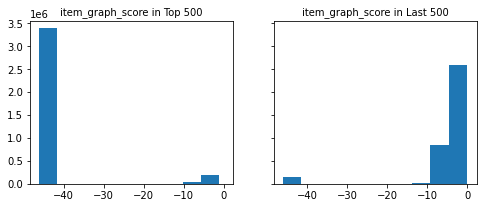

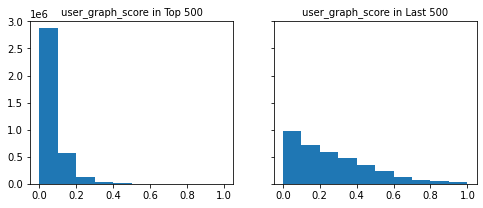

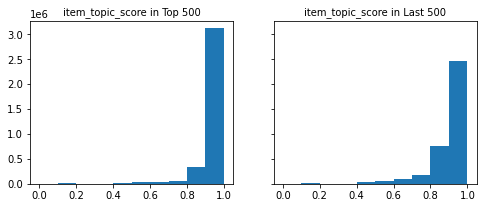

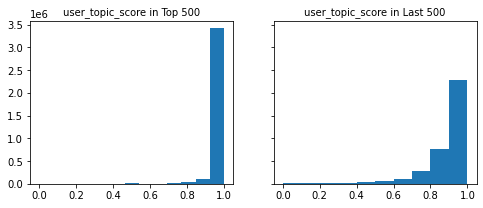

In [ ]:
visualize_recscore(rec_df, lastscore_df)

##### Get rec results

In [ ]:
get_rec_withweight('23344',None, product_mats, user_mats, product_id, user_cnt, weights, version='simple')

start_code  ...                           rec_des
0      23344  ...  CAKE STAND LOVEBIRD 2 TIER WHITE
1      23344  ...   CERAMIC STRAWBERRY TRINKET TRAY
2      23344  ...      CHRISTMAS CARD SINGING ANGEL
3      23344  ...    WHITE HONEYCOMB PAPER GARLAND 
4      23344  ...       EDWARDIAN HEART PHOTO FRAME
5      23344  ...       WOVEN SUNSET CUSHION COVER 

[6 rows x 5 columns]

In [ ]:
get_rec_withweight('23344',user_cnt.iloc[1].CustomerID, product_mats, user_mats, product_id, user_cnt, weights, version='simple')

start_code  ...                             rec_des
0      23344  ...    5 STRAND GLASS NECKLACE AMETHYST
1      23344  ...  HANGING RIDGE GLASS T-LIGHT HOLDER
2      23344  ...   GLASS BEAD HOOP EARRINGS AMETHYST
3      23344  ...        OLD ROSE COMBO BEAD NECKLACE
4      23344  ...              BLACK VINTAGE EARRINGS
5      23344  ...    SET 10 CARD KRAFT REINDEER 17084

[6 rows x 5 columns]

##### Other experiments

In [ ]:
del model_simple
model_simple = LogisticRegression_Simple().to(device)
optimizer = torch.optim.Adam(model_simple.parameters(), lr=learning_rate)
y_pred, loss_liss = train(model_simple)

Epoch 0: MSE=0.018856, MAE=0.453116, MAE_0=0.450197, MAE_1=0.539752
Epoch 4: MSE=0.018834, MAE=0.451495, MAE_0=0.448468, MAE_1=0.541327
Epoch 9: MSE=0.018807, MAE=0.449476, MAE_0=0.446316, MAE_1=0.543287
Epoch 14: MSE=0.018780, MAE=0.447476, MAE_0=0.444182, MAE_1=0.545227
Epoch 19: MSE=0.018755, MAE=0.445500, MAE_0=0.442076, MAE_1=0.547139


In [ ]:
del model_simple
model_simple = LogisticRegression_Simple().to(device)
optimizer = torch.optim.Adam(model_simple.parameters(), lr=learning_rate)
y_pred, loss_liss = train(model_simple)

Epoch 0: WBE=0.031960, MAE=0.138373, MAE_0=0.114273, MAE_1=0.853677
Epoch 4: WBE=0.031951, MAE=0.137746, MAE_0=0.113600, MAE_1=0.854416
Epoch 9: WBE=0.031939, MAE=0.136968, MAE_0=0.112765, MAE_1=0.855334
Epoch 14: WBE=0.031927, MAE=0.136196, MAE_0=0.111937, MAE_1=0.856244
Epoch 19: WBE=0.031915, MAE=0.135432, MAE_0=0.111116, MAE_1=0.857147


In [ ]:
del model_simple
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
model_simple = LogisticRegression_Simple().to(device)
optimizer = torch.optim.Adam(model_simple.parameters(), lr=learning_rate)
y_pred, loss_liss = train(model_simple)

Epoch 0: WBCE=0.980481, MAE=0.532576, MAE_0=0.537627, MAE_1=0.382639
Epoch 4: WBCE=0.979202, MAE=0.530579, MAE_0=0.535493, MAE_1=0.384754
Epoch 9: WBCE=0.977603, MAE=0.528081, MAE_0=0.532820, MAE_1=0.387404
Epoch 14: WBCE=0.976005, MAE=0.525581, MAE_0=0.530146, MAE_1=0.390060
Epoch 19: WBCE=0.974407, MAE=0.523079, MAE_0=0.527471, MAE_1=0.392724


In [ ]:
del model_simple
criterion = torch.nn.BCELoss(reduction='mean')
model_simple = LogisticRegression_Simple().to(device)
optimizer = torch.optim.Adam(model_simple.parameters(), lr=learning_rate)
y_pred, loss_liss = train(model_simple)

Epoch 0: BCE=0.164944, MAE=0.102889, MAE_0=0.074897, MAE_1=0.933711
Epoch 4: BCE=0.164595, MAE=0.102319, MAE_0=0.074289, MAE_1=0.934278
Epoch 9: BCE=0.164166, MAE=0.101613, MAE_0=0.073535, MAE_1=0.934978
Epoch 14: BCE=0.163747, MAE=0.100916, MAE_0=0.072792, MAE_1=0.935669
Epoch 19: BCE=0.163338, MAE=0.100229, MAE_0=0.072059, MAE_1=0.936349


####  *4.3.2.3 Experiments with Logistic Regression*


In [ ]:
n_users, n_items = his_matrix.shape

In [ ]:
model = LogisticRegression(n_items, n_items).to(device)
# criterion = torch.nn.BCELoss(reduction='mean')
# criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
y_pred_np, loss_list = train(model, 20) # 0.05, 0.95

Epoch 0: WBE=0.039326, MAE=0.503674, MAE_0=0.504401, MAE_1=0.482120
Epoch 4: WBE=0.017242, MAE=0.207511, MAE_0=0.206616, MAE_1=0.234088
Epoch 9: WBE=0.017224, MAE=0.206977, MAE_0=0.206053, MAE_1=0.234379
Epoch 14: WBE=0.017213, MAE=0.206653, MAE_0=0.205714, MAE_1=0.234548
Epoch 19: WBE=0.017202, MAE=0.206423, MAE_0=0.205475, MAE_1=0.234555


##### Check score

In [ ]:
print (np.sum(y_pred_np==1)/(sz[0]*sz[1]))
print (np.sum(y_pred_np>0.5)/(sz[0]*sz[1]))

0.0991191185863317
0.10145656591717998


In [ ]:
rec_df = get_productrec_hybridmodel(y_pred_np, purchase_df, product_id, product_mats, user_mats)
rec_df.head(5)

start_code  ...                          rec_des
0      22139  ...           HAND WARMER UNION JACK
1      22139  ...              HAPPY STENCIL CRAFT
2      22139  ...  RETROSPOT RED WASHING UP GLOVES
3      22139  ...         EMERGENCY FIRST AID TIN 
4      22139  ...            NO SINGING METAL SIGN

[5 rows x 9 columns]

In [ ]:
lastscore_df = get_productrec_hybridmodel(y_pred_np, purchase_df, product_id, product_mats, user_mats, metric='distance')
lastscore_df.head(5)

start_code  ...                            rec_des
0      22139  ...      FLAMES SUNGLASSES PINK LENSES
1      22139  ...  YELLOW/PINK FLOWER DESIGN BIG MUG
2      22139  ...        VINTAGE CHRISTMAS STOCKING 
3      22139  ...                 ZINC BOX SIGN HOME
4      22139  ...   GIFT BAG LARGE VINTAGE CHRISTMAS

[5 rows x 9 columns]

##### Check weights

In [ ]:
ig_w = model.linear_itemgraph.weight.cpu().detach().numpy()
ug_w = model.linear_usergraph.weight.cpu().detach().numpy()
it_w = model.linear_itemtopic.weight.cpu().detach().numpy()
ut_w = model.linear_usertopic.weight.cpu().detach().numpy()
weights={'item_graph_weight':ig_w, 'item_topic_weight':it_w, 'user_graph_weight': ug_w, 'user_topic_weight':ut_w}

In [ ]:
for k, v in weights.items():
    print (k)
    print (v)

item_graph_weight
[[-0.00686412  0.01758658  0.01575618 ... -0.00224079  0.00450923
  -0.00772377]
 [ 0.00997426  0.00802457 -0.01397913 ... -0.01907286 -0.00713731
   0.00852192]
 [ 0.00847316 -0.0029405  -0.00928255 ...  0.01996928  0.02077067
   0.02120673]
 ...
 [ 0.00186592 -0.00288882 -0.00166573 ... -0.01807905 -0.00325293
   0.00175217]
 [-0.01047266 -0.00984245  0.00338376 ... -0.01948577  0.00870216
  -0.01621922]
 [-0.02029384 -0.01014664 -0.00197748 ... -0.02086827 -0.01012394
   0.01109033]]
item_topic_weight
[[ 0.0144349   0.00501677  0.01267589 ...  0.00656963 -0.00480558
  -0.01480265]
 [-0.00390633 -0.01541974 -0.00903005 ...  0.0033174   0.01541004
  -0.00671799]
 [ 0.00173887 -0.00856094 -0.00890663 ... -0.0021507  -0.01531076
   0.01425336]
 ...
 [ 0.00685083  0.01277346  0.01325205 ...  0.01535364 -0.01248312
  -0.00638108]
 [-0.00677891 -0.00488348 -0.00272377 ... -0.00967576 -0.00927707
  -0.00618003]
 [-0.01251713  0.01149113 -0.00736963 ... -0.01634466 -0.01054

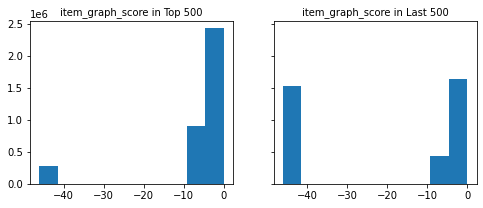

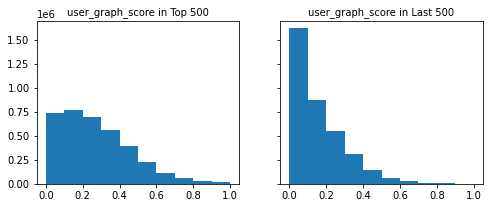

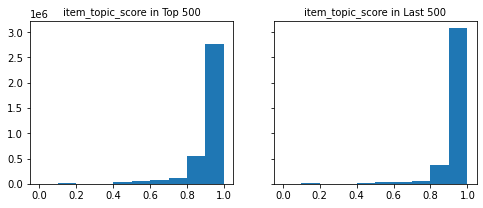

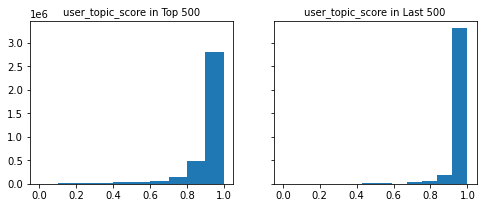

In [ ]:
visualize_recscore(rec_df, lastscore_df)

##### Get rec results

In [ ]:
get_rec_withweight('23344', None, product_mats, user_mats, product_id, user_cnt, weights)

start_code  ...                            rec_des
0      23344  ...         DANISH ROSE UMBRELLA STAND
1      23344  ...            FLAG OF ST GEORGE CHAIR
2      23344  ...           VINTAGE GOLD TINSEL REEL
3      23344  ...             WALL ART DOG AND BALL 
4      23344  ...       DROP DIAMANTE EARRINGS GREEN
5      23344  ...  PAPER CHAIN KIT VINTAGE CHRISTMAS

[6 rows x 5 columns]

In [ ]:
get_rec_withweight('23344',user_cnt.iloc[1].CustomerID, product_mats, user_mats, product_id, user_cnt, weights)

start_code  ...                              rec_des
0      23344  ...  AIRLINE BAG VINTAGE WORLD CHAMPION 
1      23344  ...                 URBAN BLACK RIBBONS 
2      23344  ...    FELTCRAFT PRINCESS CHARLOTTE DOLL
3      23344  ...       72 SWEETHEART FAIRY CAKE CASES
4      23344  ...     CAMPHOR WOOD PORTOBELLO MUSHROOM
5      23344  ...         T-LIGHT GLASS FLUTED ANTIQUE

[6 rows x 5 columns]

##### With different loss functions

- Binary Cross Error

In [ ]:
y_pred_np, loss_list =train(model, 20)

Epoch 0: BCE=0.790161, MAE=0.496838, MAE_0=0.496419, MAE_1=0.509281
Epoch 4: BCE=0.422490, MAE=0.044310, MAE_0=0.015129, MAE_1=0.910442
Epoch 9: BCE=0.371186, MAE=0.049845, MAE_0=0.020958, MAE_1=0.907247
Epoch 14: BCE=0.302153, MAE=0.053473, MAE_0=0.025528, MAE_1=0.882903
Epoch 19: BCE=0.256373, MAE=0.053634, MAE_0=0.025283, MAE_1=0.895134


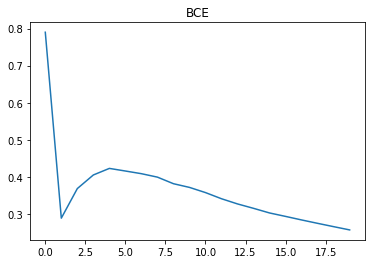

In [ ]:
snb.lineplot(x=range(len(loss_list)), y = np.array([i.item() for i in loss_list]))
plt.title('BCE')
plt.show()

- Weighted Binary Cross Error with weight_1=0.9

In [ ]:
y_pred_np, loss_list =train(model, 20)

Epoch 0: WBCE=0.964812, MAE=0.503754, MAE_0=0.504032, MAE_1=0.495491
Epoch 4: WBCE=0.693147, MAE=0.032593, MAE_0=0.000000, MAE_1=1.000000
Epoch 9: WBCE=0.693147, MAE=0.032593, MAE_0=0.000000, MAE_1=1.000000
Epoch 14: WBCE=0.693147, MAE=0.032593, MAE_0=0.000000, MAE_1=1.000000
Epoch 19: WBCE=0.693147, MAE=0.032593, MAE_0=0.000000, MAE_1=1.000000


- Weighted Mean Binary Error with weight_1=0.9

In [ ]:
y_pred_np, loss_list =train(model, 20) # 0.1, 0.9

Epoch 0: WBE=0.062868, MAE=0.498117, MAE_0=0.498029, MAE_1=0.500735
Epoch 4: WBE=0.023621, MAE=0.107465, MAE_0=0.094450, MAE_1=0.493766
Epoch 9: WBE=0.023611, MAE=0.107480, MAE_0=0.094481, MAE_1=0.493302
Epoch 14: WBE=0.023603, MAE=0.107322, MAE_0=0.094307, MAE_1=0.493616
Epoch 19: WBE=0.023593, MAE=0.107423, MAE_0=0.094438, MAE_1=0.492856


- Weighted Mean Binary Error with weight_1=0.99

In [ ]:
y_pred_np, loss_list =train(model, 20) # 0.01, 0.99

Epoch 0: WBE=0.020949, MAE=0.501357, MAE_0=0.501441, MAE_1=0.498894
Epoch 4: WBE=0.005214, MAE=0.462719, MAE_0=0.477690, MAE_1=0.018381
Epoch 9: WBE=0.005204, MAE=0.461880, MAE_0=0.476825, MAE_1=0.018312
Epoch 14: WBE=0.005192, MAE=0.460533, MAE_0=0.475429, MAE_1=0.018380
Epoch 19: WBE=0.005184, MAE=0.459940, MAE_0=0.474820, MAE_1=0.018296


In [ ]:
save_y, save_loss = y_pred_np, loss_list

- Weighted Mean Binary Error with weight_1=0.95

In [ ]:
y_pred_np, loss_list =train(model, 20) # 0.05, 0.95

Epoch 0: WBE=0.039802, MAE=0.495848, MAE_0=0.495314, MAE_1=0.511681
Epoch 4: WBE=0.017250, MAE=0.207002, MAE_0=0.206051, MAE_1=0.235222
Epoch 9: WBE=0.017239, MAE=0.208192, MAE_0=0.207362, MAE_1=0.232813
Epoch 14: WBE=0.017222, MAE=0.208472, MAE_0=0.207687, MAE_1=0.231765
Epoch 19: WBE=0.017216, MAE=0.208194, MAE_0=0.207391, MAE_1=0.232018


In [ ]:
save_y_2, save_loss_2 = y_pred_np, loss_list

- Mean Square Error with weight_1=0.95

In [ ]:
y_pred_np, loss_list = train(model, 20) # 0.05, 0.95

Epoch 0: MSE=0.023033, MAE=0.499209, MAE_0=0.499168, MAE_1=0.500424
Epoch 4: MSE=0.019851, MAE=0.221880, MAE_0=0.219215, MAE_1=0.300981
Epoch 9: MSE=0.019829, MAE=0.221731, MAE_0=0.219115, MAE_1=0.299369
Epoch 14: MSE=0.019817, MAE=0.221984, MAE_0=0.219398, MAE_1=0.298758
Epoch 19: MSE=0.019810, MAE=0.222199, MAE_0=0.219637, MAE_1=0.298257


In [ ]:
save_y_3, save_loss_3 = y_pred_np, loss_list

###### Check the best prediction

In [ ]:
y_pred_set = {'MSE_0.95': save_y_3, 'MBE_0.95': save_y_2, 'MBE_0.90':save_y}
loss_set = {'MSE_0.95': save_loss_3, 'MBE_0.95': save_loss_2, 'MBE_0.90':save_loss}

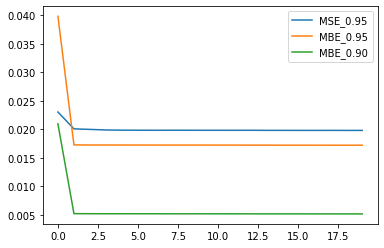

In [ ]:
for k, v in loss_set.items():
    ls = [i.item() for i in v]
    snb.lineplot(x=range(len(ls)), y = ls, label=k)
plt.show()

In [ ]:
for k, v in y_pred_set.items():
    mae, mae_0, mae_1 = cal_mae(v), cal_mae_0(v), cal_mae_1(v)
    rate = np.sum(v==1.0)*1.0/(sz[0]*sz[1])
    print ('%s: MAE=%.4f, MAE_0=%.4f, MAE_1=%.4f, 1-rate: %f' % (k, mae, mae_0, mae_1, rate))

MSE_0.95: MAE=0.2222, MAE_0=0.2196, MAE_1=0.2983, 1-rate: 0.232295
MBE_0.95: MAE=0.2082, MAE_0=0.2074, MAE_1=0.2320, 1-rate: 0.222172
MBE_0.90: MAE=0.4599, MAE_0=0.4748, MAE_1=0.0183, 1-rate: 0.485321
